<a href="https://colab.research.google.com/github/apmoore1/tdsa_comparisons/blob/master/analysis/TDSA_Baseline_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
all_results = pd.read_csv('https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/results.tsv', sep='\t')
all_results = all_results.drop(columns=['index', 'Unnamed: 0'])
all_results = all_results.replace({'Model': 'AE'}, 'Att-AE')

In [ ]:
from typing import Dict, Any, List, Tuple, Callable

import numpy as np
from target_extraction.analysis.util import long_format_metrics, metric_p_values

def filter_df(df: pd.DataFrame, column_value: Dict[str, Any]) -> pd.DataFrame:
  filtered_df = df.copy(deep=True)
  for column_name, filter_value in column_value.items():
    filtered_df = filtered_df[filtered_df[f'{column_name}']==filter_value]
  return filtered_df

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def p_value_count(alpha: float) -> Callable[[pd.Series], float]:
  def alpha_count(p_values: pd.Series) -> float:
    significant_p_values = p_values <= alpha
    return int(np.sum(significant_p_values))
  return alpha_count
DATASET_COLUMN_ORDER = ['Election', 'Laptop', 'Restaurant']
ROW_ERROR_SPLIT_ORDER = ['NT', 'DS', 'TSSR', 'n-shot', 'TSR']
SPLIT_ORDER = ['Validation', 'Test']

# Baseline TDSA results

In this notebook we explore how the baseline models:
1. Perform in general i.e. overall accuracy and macro f1 scores
2. The perform of these models across the different error analysis splits

The baseline models used:
1. CNN Text classifier that has not knowledge of the target only the context. Model comes from [Kim 2014](https://www.aclweb.org/anthology/D14-1181/)
2. [**TDLSTM**](https://www.aclweb.org/anthology/C16-1311.pdf)
3. [**IAN**](https://www.ijcai.org/proceedings/2017/0568.pdf)
4. **Att-AE** (We called it *AE* when running the experiments and that is what it is called in the original data) -- A model that is the same as the *AE* model from [Wang et al. 2016](https://www.aclweb.org/anthology/D16-1058.pdf) but with an attention layer after the LSTM enocder. This model is also the same as the inter-aspect model (from now on called **Inter-AE**) from [Hazarika et al. 2018](https://www.aclweb.org/anthology/N18-2043/) but without the LSTM aspect encoder (phase 2 in figure 1) that models other targets from the same context/text. 

## Overall Performance

Here we show the difference in overall performance between the 4 classifiers, where all results will show the mean and standard deviation of the metric score from the 8 runs the model performed on the relevant dataset.

Before calculating those results we need to filter the results table so that it only shows the results for the baseline models and not for the enhanced models (enhanced models are those that either use Position informance, CWR, or Inter-Aspect encoding). Below shows the table of results un-filtered, where this shows all of the results from all of the experiments:

In [ ]:
all_results

,prediction key,run number,Accuracy,Inter-Aspect,Position,CWR,Model,Macro F1,STAC Multi,STAC 1,...,low-targets,med-shot,med-targets,unknown_sentiment_known_target,unknown_targets,zero-shot,Data Split,Total Sentences,DS 1 Sentences,DS 2 and 3 Sentences
0,predicted_target_sentiment_AE_CWR_None_None,0,0.608422,False,False,True,Att-AE,0.527394,0.124365,0.515991,...,0.610197,0.593407,0.618132,0.257143,0.668407,0.668407,Test,863,469,394
1,predicted_target_sentiment_AE_CWR_None_None,1,0.601338,False,False,True,Att-AE,0.503514,0.137056,0.494670,...,0.601151,0.587912,0.627747,0.257143,0.637076,0.637076,Test,863,469,394
2,predicted_target_sentiment_AE_CWR_None_None,2,0.582054,False,False,True,Att-AE,0.410102,0.134518,0.477612,...,0.571546,0.538462,0.598901,0.380952,0.608355,0.608355,Test,863,469,394
3,predicted_target_sentiment_AE_CWR_None_None,3,0.604486,False,False,True,Att-AE,0.495700,0.142132,0.498934,...,0.607730,0.589286,0.603022,0.276190,0.642298,0.642298,Test,863,469,394
4,predicted_target_sentiment_AE_CWR_None_None,4,0.588745,False,False,True,Att-AE,0.501395,0.129442,0.486141,...,0.582237,0.570055,0.618132,0.238095,0.608355,0.608355,Test,863,469,394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,predicted_target_sentiment_TDLSTM_GloVe_None_s...,3,0.713129,sequential,False,False,TDLSTM,0.604740,0.135922,0.716298,...,0.702857,0.728659,0.726190,0.312500,0.706485,0.706485,Validation,600,497,103
812,predicted_target_sentiment_TDLSTM_GloVe_None_s...,4,0.715827,sequential,False,False,TDLSTM,0.592949,0.106796,0.728370,...,0.697143,0.731707,0.750000,0.375000,0.713311,0.713311,Validation,600,497,103
813,predicted_target_sentiment_TDLSTM_GloVe_None_s...,5,0.724820,sequential,False,False,TDLSTM,0.615518,0.174757,0.730382,...,0.711429,0.743902,0.742063,0.375000,0.720137,0.720137,Validation,600,497,103
814,predicted_target_sentiment_TDLSTM_GloVe_None_s...,6,0.721223,sequential,False,False,TDLSTM,0.584065,0.116505,0.750503,...,0.688571,0.716463,0.746032,0.375000,0.703072,0.703072,Validation,600,497,103


Filterting for only the baseline models which are those only using GloVe embeddings and no Poisition, Contextualised Word Representations (CWR), or Inter-Aspect encoding:

In [ ]:
column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': False}
overall_results = filter_df(all_results, column_values)

overall_validation_results = overall_results[overall_results['Data Split']=='Validation']
overall_test_results = overall_results[overall_results['Data Split']=='Test']

Now the results have been filtered to only values that have come from the relevant baseline models we can show the table of results.

Validation:

In [ ]:
pd.pivot_table(overall_validation_results, index='Model', columns='Dataset', 
               values=['Macro F1', 'Accuracy'], 
               aggfunc={'Accuracy': mean_std, 
                        'Macro F1': mean_std}).T

Model                      Att-AE           CNN           IAN        TDLSTM
         Dataset                                                           
Accuracy Election    58.42 (0.40)  54.07 (0.56)  60.14 (0.40)  58.73 (0.38)
         Laptop      70.74 (0.75)  70.65 (0.68)  71.57 (0.64)  69.69 (0.63)
         Restaurant  71.99 (0.45)  72.31 (0.69)  72.13 (0.57)  72.43 (0.46)
Macro F1 Election    46.05 (1.85)  42.74 (2.09)  45.80 (1.48)  46.83 (1.80)
         Laptop      66.28 (1.21)  66.32 (0.96)  66.94 (1.32)  65.74 (1.00)
         Restaurant  60.77 (0.67)  60.51 (1.20)  60.84 (1.08)  61.63 (0.87)

Test:

In [ ]:
pd.pivot_table(overall_test_results, index='Model', columns='Dataset', 
               values=['Macro F1', 'Accuracy'], 
               aggfunc={'Accuracy': mean_std, 
                        'Macro F1': mean_std}).T

Model                      Att-AE           CNN           IAN        TDLSTM
         Dataset                                                           
Accuracy Election    56.49 (0.76)  52.35 (0.69)  58.60 (0.36)  58.39 (0.74)
         Laptop      67.99 (1.30)  68.26 (0.69)  66.58 (0.53)  67.46 (1.60)
         Restaurant  76.62 (0.59)  75.81 (0.55)  76.51 (1.49)  76.09 (0.62)
Macro F1 Election    44.23 (1.81)  39.98 (2.20)  43.90 (1.52)  46.95 (2.33)
         Laptop      59.97 (2.29)  60.43 (1.36)  58.78 (0.62)  60.52 (2.63)
         Restaurant  61.01 (1.47)  59.40 (1.52)  61.22 (2.85)  61.59 (1.57)

As the results can be better seen through a plot we are going to re-arrange the results so that the information is in a better format for plotting:

In [ ]:
plotting_results = long_format_metrics(all_results, ['Accuracy', 'Macro F1'])
overall_plotting_results = filter_df(plotting_results, column_values)
overall_plotting_results['Metric Score'] = overall_plotting_results['Metric Score'] * 100

Plotting those results:

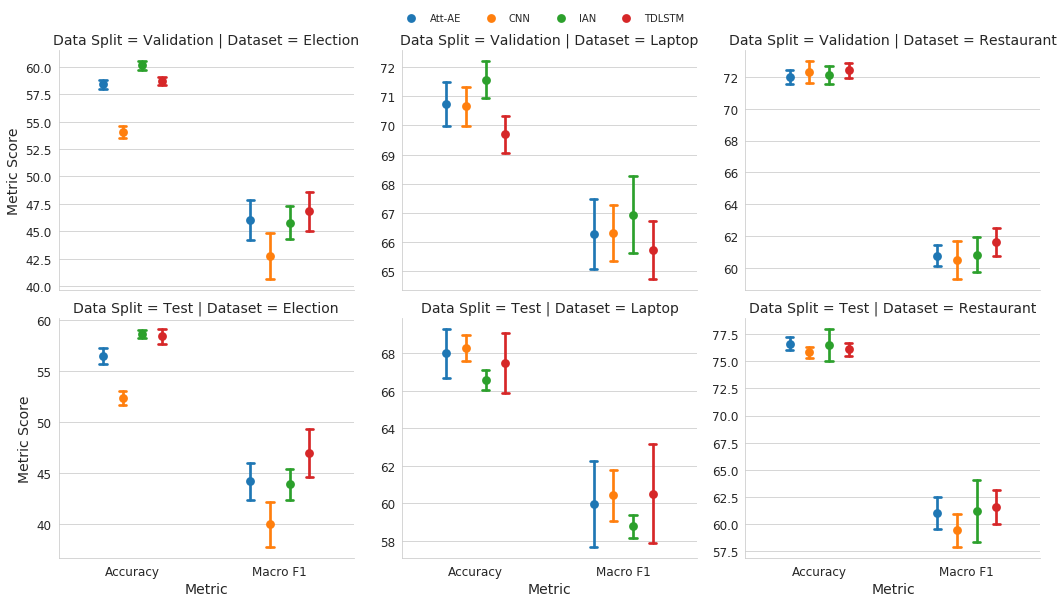

In [ ]:
import seaborn as sns
import matplotlib
matplotlib.rc('font', size=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

cat_plot = sns.catplot(x='Metric', y='Metric Score',  data=overall_plotting_results, 
                kind='point', col='Dataset', ci='sd', join=False, capsize=.05,
                hue='Model' ,dodge=0.4, sharey=False, row='Data Split',
                legend=False,
                row_order=SPLIT_ORDER, col_order=DATASET_COLUMN_ORDER)
cat_plot.fig.set_size_inches(15,8)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, bbox_to_anchor=(0.29, 1))


From both the plot and the table of results the main finding is that a text classification model is a very strong baseline as shown by [Tang et al. 2016](https://www.aclweb.org/anthology/D16-1021/), [Wang et al. 2016](https://www.aclweb.org/anthology/D16-1058.pdf), [He et al. 2018](https://www.aclweb.org/anthology/P18-2092/), and [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/). The only dataset that the *CNN* model performs a lot worse on is the Election dataset, of which this is most likely due to the Election dataset having the least number of samples that contain only one unique sentiment.

All of the TDSA models were compared to a LSTM text classsification baseline in there original papers and follow up paper for the [TDLSTM](https://www.aclweb.org/anthology/D16-1021/). However this text classification baseline was never explained fully, as in the way that the baseline was trained. The baseline could have been trained in at least 3 different ways: 

1. Use all of the samples even if the samples sentiment contradicted each other.
2. Only use samples where the text contain only has one unique sentiment.
3. Take the sentiment of the majority class for each text and thus use all of the samples where a sample here is a text rather than a target as is the case in version 1 of this list.

For our *CNN* baseline we use method 3. However as each of these method main encoders are *LSTM* based and [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/) showed on the Restaurant dataset that the *CNN* is a stronger text classification baseline we have applied the *CNN* to two more datasets than [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/) showing that *CNN* can be a powerful baseline for the Laptop datasets as well and for the Macro F1 metric as [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/) only evaluated on the Accuracy metric.

Below we also compare the original methods results from the relevant papers to ours (only show accuracy scores as none of the original papers report macro f1 scores). The scores for the original methods are those with the (O) after the model name:

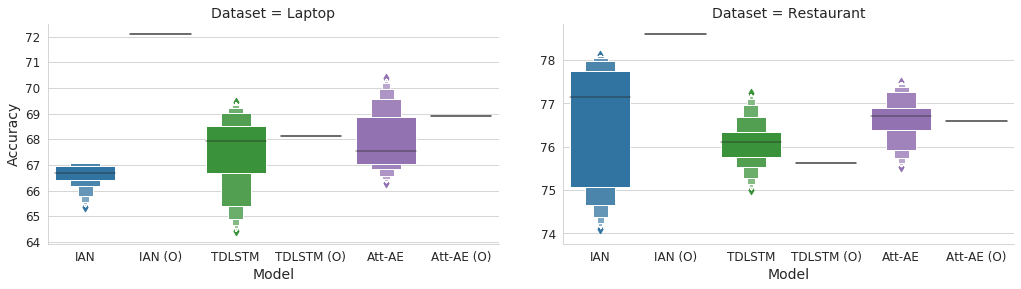

In [ ]:
def reproduction_plot(test_df: pd.DataFrame) -> sns.axisgrid.FacetGrid:
  drop_columns = test_df.columns.tolist()
  drop_columns = [column for column in drop_columns 
                  if column not in ['Model', 'Dataset', 'Accuracy']]
  repro_test_df = test_df.drop(columns=drop_columns)
  repro_test_df = repro_test_df[repro_test_df['Model']!='CNN']
  repro_test_df = repro_test_df[repro_test_df['Dataset']!='Election']
  repro_test_df['Accuracy'] = (repro_test_df['Accuracy'].round(4)) * 100
  model_names = ['IAN (O)', 'IAN (O)', 'TDLSTM (O)', 'TDLSTM (O)', 
                 'Att-AE (O)', 'Att-AE (O)']
  dataset_names = ['Laptop', 'Restaurant', 'Laptop', 'Restaurant', 
                   'Laptop', 'Restaurant']
  accuracies = [72.1, 78.6, 68.13, 75.63, 68.9, 76.6]
  originals_df = pd.DataFrame({'Model': model_names, 'Dataset': dataset_names, 
                               'Accuracy': accuracies})
  repro_test_df = repro_test_df.append(originals_df, ignore_index=True, 
                                       sort=False)
  
  model_order = ['IAN', 'IAN (O)', 'TDLSTM', 'TDLSTM (O)', 'Att-AE', 
                 'Att-AE (O)']

  return sns.catplot(x="Model", y='Accuracy', data=repro_test_df, col='Dataset',
                    kind='boxen', sharey=False, col_order=DATASET_COLUMN_ORDER[1:],
                    order=model_order)

cat_plot = reproduction_plot(overall_test_results)
cat_plot.fig.set_size_inches(15,4)

As we can see from the graph only IAN we do not get similar scores to the original paper, we believe this is due to the use of a different optimiser as in the original paper they use [Stochastic Gradient Descent with momentum](https://www.sciencedirect.com/science/article/abs/pii/S0893608098001166?via%3Dihub) where as we use [ADAM](https://arxiv.org/abs/1412.6980).


### Are the TDSA methods statistically significantly better than a Text Classifier
From these results we test to see if any of the TDSA classifiers are statistically signficantly better than the text classifier (*CNN*). None of the original papers test for statistical significance as they only show that their new method is better than the text classification baseline. Furthermore the text classification baseline also always used the same encoder (LSTM) as the new TDSA method they created. The table below states the number of TDSA models out of the 3 which are statistically significantly better than the *CNN* model:

In [ ]:
alpha = 0.05
metric_assumed_normal = [('Accuracy', True), ('Macro F1', True)]
dataset_names = ['Laptop', 'Restaurant', 'Election']
tdsa_model_names = ['TDLSTM', 'Att-AE', 'IAN']
all_p_values = []
for split_name, data_df in [('Validation', overall_validation_results), 
                            ('Test', overall_test_results)]:
  for tdsa_model_name in tdsa_model_names:
    p_value_df = metric_p_values(data_df, f'{tdsa_model_name}', ['CNN'], 
                                 dataset_names, metric_assumed_normal)
    p_value_df['Split'] = split_name
    all_p_values.append(p_value_df)
combined_cnn_p_values = pd.concat(all_p_values, sort=False, ignore_index=True)
pd.pivot_table(data=combined_cnn_p_values, values='P-Value', columns='Dataset', 
               index=['Split', 'Metric'], aggfunc=p_value_count(alpha))


Dataset              Election  Laptop  Restaurant
Split      Metric                                
Test       Accuracy       3.0     0.0         1.0
           Macro F1       3.0     0.0         2.0
Validation Accuracy       3.0     1.0         0.0
           Macro F1       3.0     0.0         1.0

Below we show the exact P-Values for each model across the datasets and evaluation metrics:

In [ ]:
pd.pivot_table(data=combined_cnn_p_values, values='P-Value', columns='Dataset', 
               index=['Better Model' ,'Split', 'Metric'])

Dataset                               Election    Laptop  Restaurant
Better Model Split      Metric                                      
Att-AE       Test       Accuracy  2.147997e-08  0.683750    0.009696
                        Macro F1  7.860032e-04  0.671443    0.032267
             Validation Accuracy  2.578713e-10  0.402771    0.841210
                        Macro F1  3.760008e-03  0.524136    0.311463
IAN          Test       Accuracy  2.213951e-10  0.999907    0.139068
                        Macro F1  1.023495e-03  0.992310    0.082932
             Validation Accuracy  3.981701e-12  0.010289    0.698269
                        Macro F1  3.964224e-03  0.164457    0.300675
TDLSTM       Test       Accuracy  1.292512e-10  0.873634    0.194028
                        Macro F1  2.533185e-05  0.468924    0.009524
             Validation Accuracy  1.268846e-10  0.991967    0.363793
                        Macro F1  8.076217e-04  0.855627    0.034230

As shown the Election dataset across the two metrics is the only dataset where all 3 TDSA methods are better than the standard text classifier (*CNN*). This is most likley due to what was stated before, that the Election dataset having the least number of samples that contain only one unique sentiment.

Furthermore below we apply the Bonferroni correction to the P-Values after being broken down by metric and split:

In [ ]:
from target_extraction.analysis.statistical_analysis import find_k_estimator

for split_name in ['Test', 'Validation']:
  split_cnn_p_values = combined_cnn_p_values[combined_cnn_p_values['Split']==split_name]
  for metric_name in ['Accuracy', 'Macro F1']:
    metric_cnn_p_values = split_cnn_p_values[split_cnn_p_values['Metric']==metric_name]
    num_sig_tests = len(metric_cnn_p_values)
    p_value_correction = find_k_estimator(metric_cnn_p_values['P-Value'], 
                                          alpha=alpha, method='B')
    print(f'For the {split_name} split the TDSA methods are statistically significantly '
          f'better than the CNN model on {p_value_correction} out of the {num_sig_tests}'
          f' significance tests when evaluated using the {metric_name} metric.')


For the Test split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Accuracy metric.
For the Test split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Macro F1 metric.
For the Validation split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Accuracy metric.
For the Validation split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Macro F1 metric.


As stated only 3 of the evaluations out of the 9 for each split and metric are significant after the Bonferroni correction has been applied.

## Performance of the models when broken down into different error splits

The different error splits that will be explored are the following:
1. Distinct Sentiment (*DS*)
2. Number Targets (*NT*)
3. Target Sentence Sentiment Ratio (*TSSR*)
4. *n-shot*
5. Target Sentiment Relation (*TSR*)

Of which error splits 1, 2, and 3 are local where as the rest are global.

As all of the metrics have been created for these splits we just need to relate the subset metric information to there respective error split and re-filter for the baseline models again:

In [ ]:
from target_extraction.analysis.sentiment_error_analysis import (ERROR_SPLIT_SUBSET_NAMES,
                                                                 PLOT_SUBSET_ABBREVIATION,
                                                                 subset_name_to_error_split)

all_subset_names = [name for subset_names in ERROR_SPLIT_SUBSET_NAMES.values() 
                    for name in subset_names]
all_subset_results = long_format_metrics(all_results, all_subset_names)
all_subset_results = all_subset_results.rename(columns={'Accuracy': 'Overall Accuracy'})
all_subset_results['Overall Accuracy'] = all_subset_results['Overall Accuracy'] * 100
all_subset_results = all_subset_results.drop(columns='Macro F1')
all_subset_results['Error Split'] = all_subset_results.apply(lambda x: subset_name_to_error_split(x['Metric']), 1)
all_subset_results['Accuracy'] = all_subset_results['Metric Score'] * 100
all_subset_results = all_subset_results.rename(columns={'Metric': 'Error Subset'})
all_subset_results['Error Subset'] = all_subset_results.apply(lambda x: PLOT_SUBSET_ABBREVIATION[x['Error Subset']], 1)
all_subset_results = all_subset_results.drop(columns=['Metric Score'])

column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': False}
overall_subset_results = filter_df(all_subset_results, column_values)

overall_subset_validation_results = overall_subset_results[overall_subset_results['Data Split']=='Validation']
overall_subset_test_results = overall_subset_results[overall_subset_results['Data Split']=='Test']

Below we plot the baseline results from all of the error splits and their respective error subsets for the validation set:

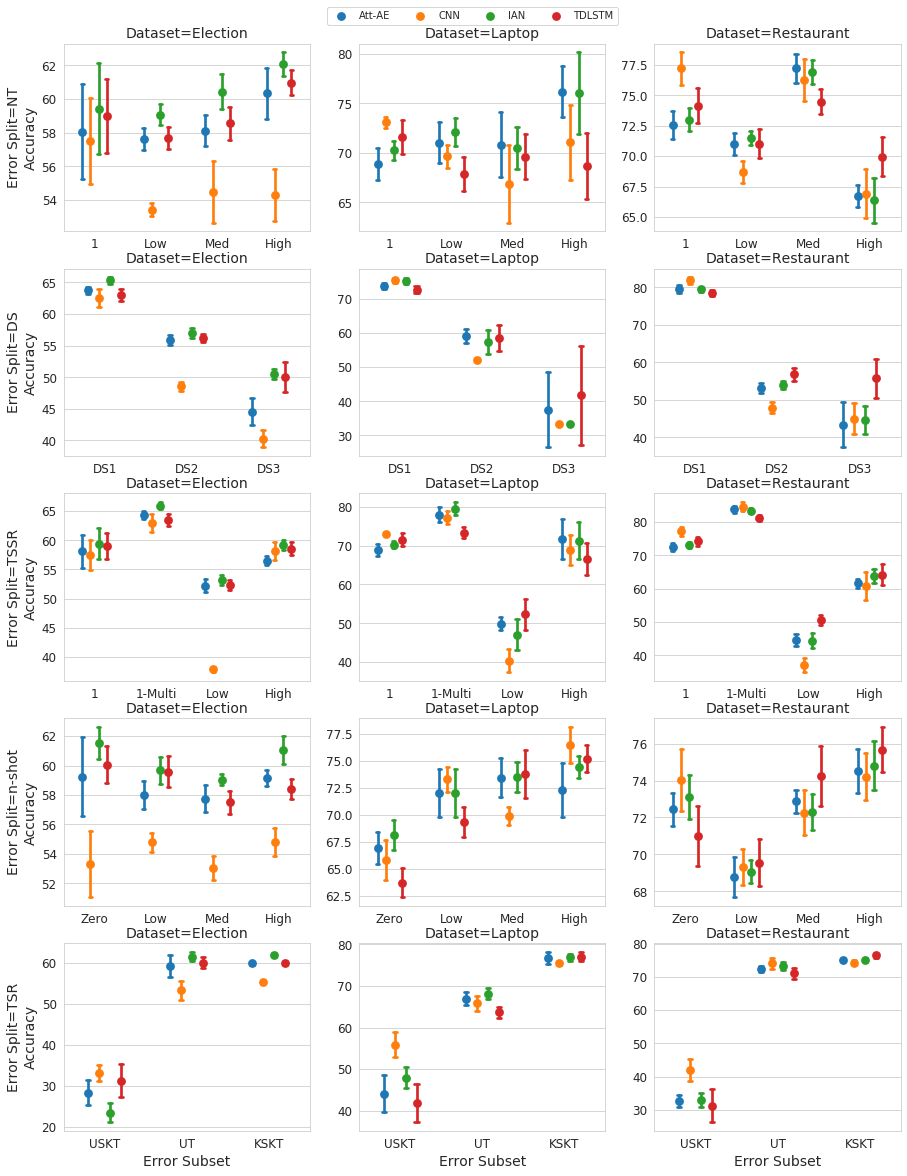

In [ ]:
from target_extraction.analysis.util import plot_error_subsets
_, _ = plot_error_subsets(overall_subset_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          row_order=ROW_ERROR_SPLIT_ORDER, 
                          column_order=DATASET_COLUMN_ORDER)

The test results:

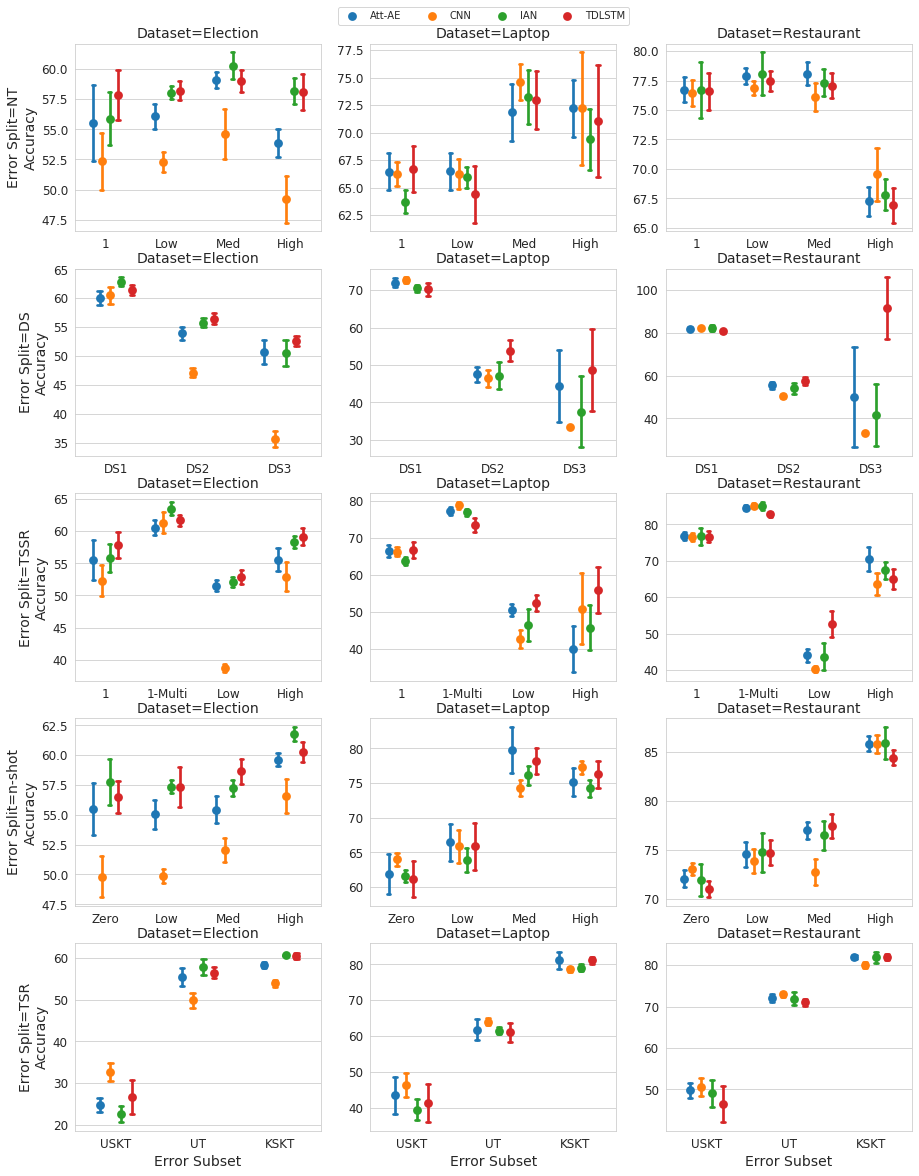

In [ ]:
_, _ = plot_error_subsets(overall_subset_test_results, 'Dataset', 'Error Split', 
                         'Error Subset', 'Accuracy', df_hue_name='Model',
                         legend_column=1, title_on_every_plot=True,
                         row_order=ROW_ERROR_SPLIT_ORDER, 
                         column_order=DATASET_COLUMN_ORDER)

From the above plots we can see that for the *DS* split on the Restaurant and Laptop datasets that $DS_3$ subset can be very volatile as shown by the error bars thus for all future plots we remove these subsets from all plots. The reason for the volatility is most likely due to the low number of samples within that subset.

In [ ]:
all_subset_results = all_subset_results[~((all_subset_results['Error Subset']=='DS3')&
                                          (all_subset_results['Dataset']!='Election'))]
# Creating the accuracy difference between the Error subsets and the overall
# accuracy
all_subset_results['Accuracy Difference'] = all_subset_results.apply(lambda x: x['Accuracy'] - x['Overall Accuracy'], 1)
column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': False}
overall_subset_results = filter_df(all_subset_results, column_values)

overall_subset_validation_results = overall_subset_results[overall_subset_results['Data Split']=='Validation']
overall_subset_test_results = overall_subset_results[overall_subset_results['Data Split']=='Test']

New Baseline **absolute** validation results:

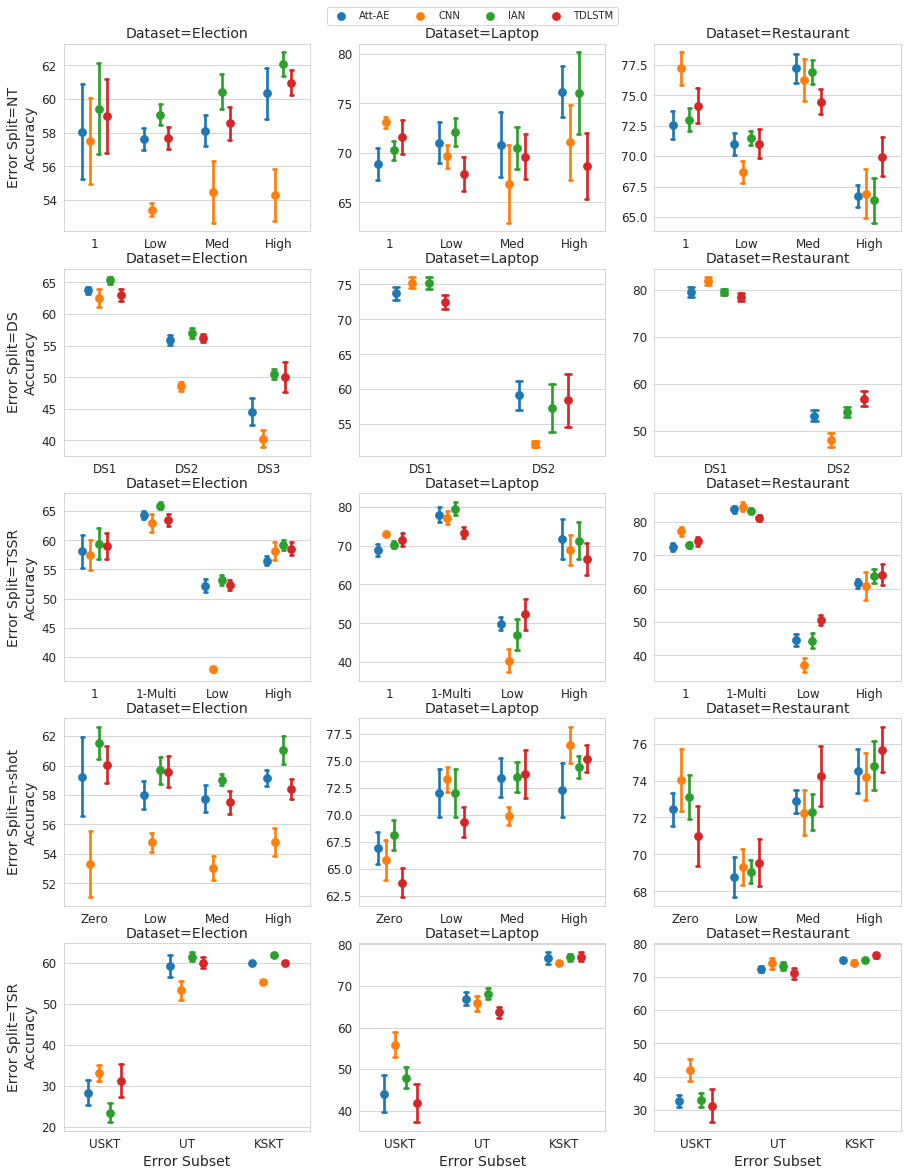

In [ ]:
from target_extraction.analysis.util import plot_error_subsets
_, _ = plot_error_subsets(overall_subset_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          row_order=ROW_ERROR_SPLIT_ORDER, 
                          column_order=DATASET_COLUMN_ORDER)

New Baseline **absolute** test results:

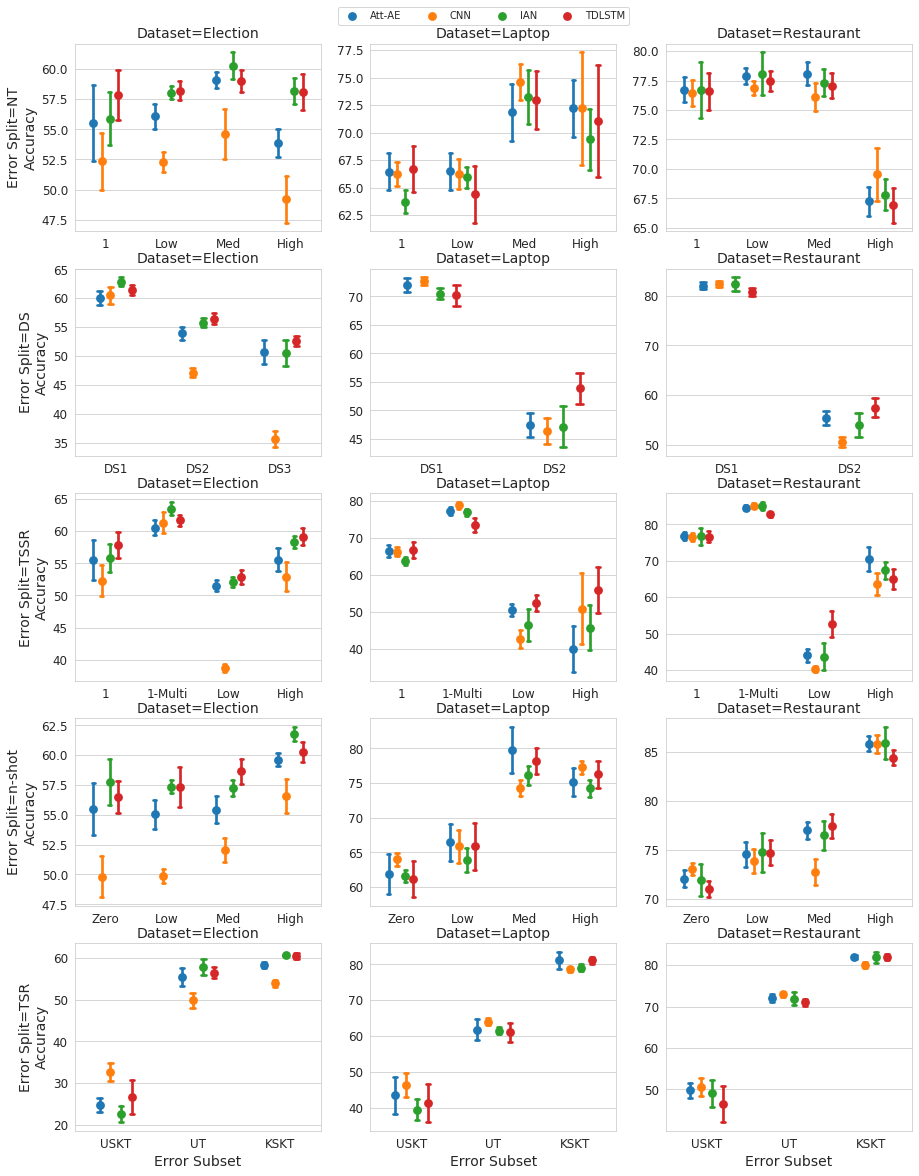

In [ ]:
_, _ = plot_error_subsets(overall_subset_test_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          row_order=ROW_ERROR_SPLIT_ORDER, 
                          column_order=DATASET_COLUMN_ORDER)

A potentially better way of visualising these results would be through subtracting the Error Subset accuracy from the overall accuracy. These plots can be seen below and will be called our **relative** results:

Validation plot:

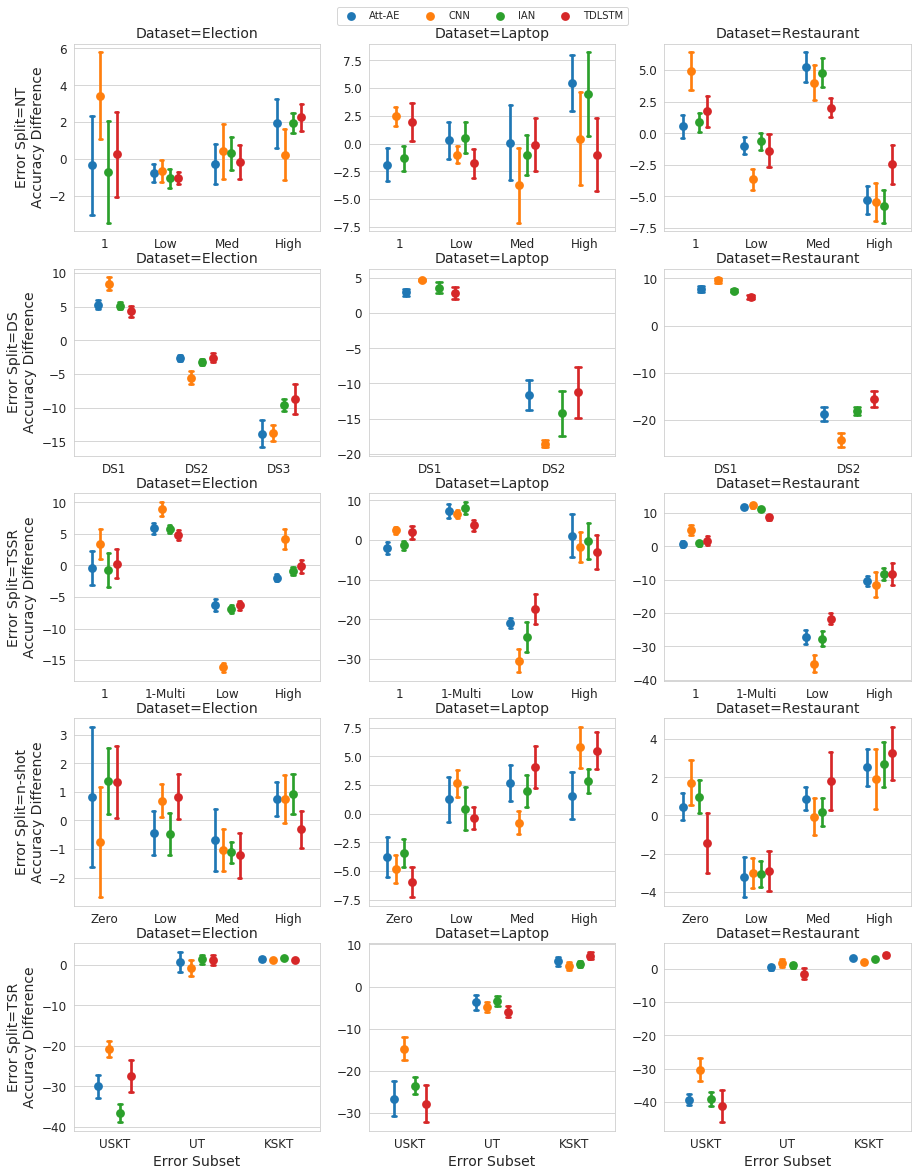

In [ ]:
_, _ = plot_error_subsets(overall_subset_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy Difference', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          row_order=ROW_ERROR_SPLIT_ORDER, 
                          column_order=DATASET_COLUMN_ORDER)

**Relative** test results

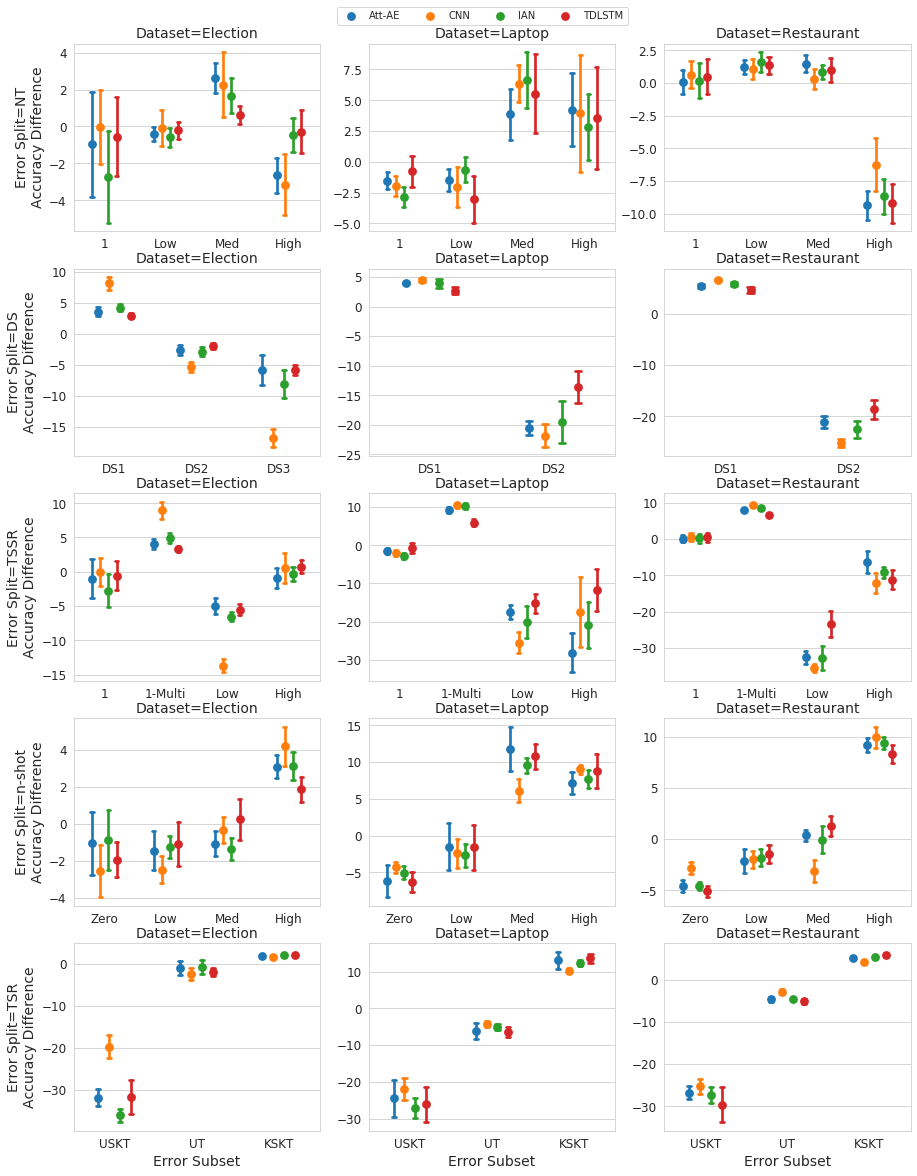

In [ ]:
_, _ = plot_error_subsets(overall_subset_test_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy Difference', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          row_order=ROW_ERROR_SPLIT_ORDER, 
                          column_order=DATASET_COLUMN_ORDER)

Generally from all of the results plotted we can see some trends that are consistent in both Test and Validation splits:

1. *DS* split, as expected, increases in difficulty as the number of unique
sentiments in the text increases, thus showing that target sentiment
relation extraction to be a difficult task for the model to perform.
Furthermore it can be seen that on average the TDLSTM model
performs consistently well on the $DS_2$ and $DS_3$ subsets where in the
DS3 subset for Election the Att-AE model performs comparable to the
text classification model. Overall this shows that the TDSA models
can make great gains by better modelling the target sentiment relationship.
2. *NT* split does not have a consistent affect on the performance of the
models, this was also found in the original paper ([Zhang et al., 2019](https://arxiv.org/pdf/1909.03477.pdf)).
One would expect texts that contain a lot of targets to be more difficult and at times it is as shown by the Restaurant dataset. However
on the other two datasets this is not the case. Furthermore the performance across the subsets can differ between datasets splits e.g. the
performance of all models on the med-targets subset on the Election
dataset is worse than high-targets for all models on the test split but
on the validation split the opposite is true. This would suggest
that even though theoretically a text with more targets should be more
difficult for a model to classify, due to the complexities of matching
targets to their respective sentiments ([Zhang et al., 2019](https://arxiv.org/pdf/1909.03477.pdf)), this is not
the case. Thus later in this notebook we investigate
what other factors are influencing the change in performance within
the *NT* split. However for now it can be concluded that *NT* cannot
effectively evaluate the target interaction as no consistent trend can
be found in this split.
3. *TSSR* As expected the *1-Multi* subset is by far the easiest subset to
classify suggesting that the models are exploiting the fact that all
targets have the same sentiment. The *1* subset tends to perform the
next best with the *high* subset at times quite close if not the same. A
reason for the *high* subset to have such high performance across the
models could be due to the models overfitting to the most frequent
sentiment class in the text. As expected
the *low* subset is by far the worse across all datasets and models and
in some cases harder to classify than samples within $DS_2$ and $DS_3$.
Only on the Laptop test split is the *high* scores similar to the *low*,
of which this might be due to the lack of samples for the *high* subset
(5% of the dataset) compared to the (11.1% of the dataset) in the *low*
subset, which is also suggested by the large error bars. Furthermore
the sentiment overfitting which this split is suppose to measure does
show to some extent where the TDSA model, *TDLSTM*, that performs
consistently better or at least as good in the $DS_2$ and $DS_3$ subsets
tends to have a smaller difference between subset *1-Multi* and *1*, and
is consistently a lot higher than the text classifier on the *low* subset.
However this split does not measure sentiment overfitting explicitly very
well without the text classification baseline and the *DS* split. For
example without *DS* and the text classification baseline it would be
impossible to know that the *TDLSTM* is performing target sentiment
relation well on the laptop dataset as the $DS_2$ subset performance
could be high due to *TDLSTM* predicting the most frequent sentiment
class. This cannot be the case as the performance of *TDLSTM* on
the *high* and *low TSSR* subsets are both above the text classification
model unlike the other two TDSA models. Though this is a rather
loose way of measuring sentiment overfitting. We hypothesised that the difference between the high and low subsets indicates sentiment overfitting, but as can be seen from the figures *TDLSTM* that is suppose to not be overfitting as much as the other TDSA models does indeed contain a low difference between *high* and *low* on the Laptop dataset, but so does *IAN* thus makes the hypothesis less likely to be true. Therefore to conclude on the *TSSR* split, it cannot measure sentiment overfitting nor would it be able to measure target interaction either as it would be impossible to know if it was target interaction or sentiment overfitting. However there are clear signs that the subsets measure to some degree target sentiment relation extraction as the score of subsets *1*, *high*, and *low* are similar in order to subsets $DS_1$, $DS_2$, and $DS_3$ respectively and these subsets co-occur frequently.
4. *TSR* again the finding is expected where the *USKT* is by far the
most difficult subset. The *UT* is more difficult in general than the *KSKT* but with a much smaller margin. This finding is therefore in
line with the relation extraction literature where unknown entities are
easier to predict than unknown relations ([Levy et al., 2017](https://www.aclweb.org/anthology/K17-1034/); [Abdou
et al., 2019](https://arxiv.org/pdf/1908.05111.pdf)). Within the validation results for the Election dataset
the margin between *UT* and *KTKS* is very small. This very much
suggests that the models do require a certain amount of supervision
for all targets in all sentiment classes or else they bias the target more
towards one sentiment class than another. This type of bias can be
very harmful as shown by the *USKT*. This could suggest a reason why
the margin between *UT* and *KSKT* is so small as some of the *KSKT*
targets might not occur in enough samples within a sentiment class. Furthermore the *KSKT* subset can be seen as the upper limit for the other two subsets as it can be seen as the data rich subset.
5. *n-shot* the expected result can be clearly seen in all the datasets within
the test split but less so within the validation split. Where the expectation is that the greater *n* is the easier the subset will be. Within the
validation split the Election and to some extent Restaurant datasets
are the major outliers, where no matter what the subset is, the scores
are almost all the same. The reason for this could be that the
validation split is used in early stopping therefore some information is
leaked to the model. As both the *n-shot* and *TSR* splits measure a
models generalisation to new targets, from the results shown it would
appear that *TSR* does this more explicitly. The *TSR* split unlike the *n-shot* models both the unseen targets and unseen relations of which modelling both has been shown through *TSR* to be crucial. This finding can possibly
explain why the *n-shot* subsets do not show a positive correlation between *n* and the metric score. Furthermore the *TSR KSKT* subset is
always the best performing subset within the split unlike the *high* in
the *n-shot*. Thus for exploring a models ability to generalise to unknown targets and unknown sentiment relations *TSR* is recommended compared to *n-shot*.

### Differences between TDSA and the Text Classification Model

Using the figures above we can see some differences already between the text classifier (*CNN*) and the TDSA models. However to see these differences more explictly we plot below heatmaps showing on the left (first column) the number of TDSA models that are statistically significantly better than the text classifier. On the right (second column) is the number of TDSA models that the text classifier is statistically significantly better. These differences have been broken down into the different error subsets. Also differences have a confidence level of 95% ($p \leq 0.05$)

In [ ]:
#@title
from target_extraction.analysis.util import create_subset_heatmap
# Get P-values testing if TDSA models are no better than text classification 
# model
alpha = 0.05
metric_assumed_normal = [('Accuracy', True)]
dataset_names = ['Laptop', 'Restaurant', 'Election']
tdsa_model_names = ['TDLSTM', 'Att-AE', 'IAN']
all_error_subset_p_values = []
for split_name, data_df in [('Validation', overall_subset_validation_results), 
                            ('Test', overall_subset_test_results)]:
  error_splits = data_df['Error Split'].unique().tolist()
  for error_split in error_splits:
    error_split_data_df = data_df[data_df['Error Split']==error_split]
    error_subsets = error_split_data_df['Error Subset'].unique().tolist()
    for error_subset in error_subsets:
      error_subset_df = error_split_data_df[error_split_data_df['Error Subset'] == error_subset]
      for tdsa_model_name in tdsa_model_names:
        p_value_df = metric_p_values(error_subset_df, f'{tdsa_model_name}', 
                                     ['CNN'], dataset_names, metric_assumed_normal)
        p_value_df['Split'] = split_name
        p_value_df['Error Subset'] = error_subset
        p_value_df['Error Split'] = error_split
        all_error_subset_p_values.append(p_value_df)
combined_error_subset_p_values_tdsa = pd.concat(all_error_subset_p_values, sort=False, 
                                           ignore_index=True)
test_combined_error_subset_p_values_tdsa = combined_error_subset_p_values_tdsa[combined_error_subset_p_values_tdsa['Split']=='Test']
val_combined_error_subset_p_values_tdsa = combined_error_subset_p_values_tdsa[combined_error_subset_p_values_tdsa['Split']=='Validation']

# Get P-Values testing if text classification models are no better than 
# TDSA models
alpha = 0.05
metric_assumed_normal = [('Accuracy', True)]
dataset_names = ['Laptop', 'Restaurant', 'Election']
tdsa_model_names = ['TDLSTM', 'Att-AE', 'IAN']
all_error_subset_p_values = []
for split_name, data_df in [('Validation', overall_subset_validation_results), 
                            ('Test', overall_subset_test_results)]:
  error_splits = data_df['Error Split'].unique().tolist()
  for error_split in error_splits:
    error_split_data_df = data_df[data_df['Error Split']==error_split]
    error_subsets = error_split_data_df['Error Subset'].unique().tolist()
    for error_subset in error_subsets:
      error_subset_df = error_split_data_df[error_split_data_df['Error Subset'] == error_subset]
      p_value_df = metric_p_values(error_subset_df, 'CNN', 
                                    tdsa_model_names, dataset_names, metric_assumed_normal)
      p_value_df['Split'] = split_name
      p_value_df['Error Subset'] = error_subset
      p_value_df['Error Split'] = error_split
      all_error_subset_p_values.append(p_value_df)
combined_error_subset_p_values_cnn = pd.concat(all_error_subset_p_values, sort=False, 
                                               ignore_index=True)
test_combined_error_subset_p_values_cnn = combined_error_subset_p_values_cnn[combined_error_subset_p_values_cnn['Split']=='Test']
val_combined_error_subset_p_values_cnn = combined_error_subset_p_values_cnn[combined_error_subset_p_values_cnn['Split']=='Validation']

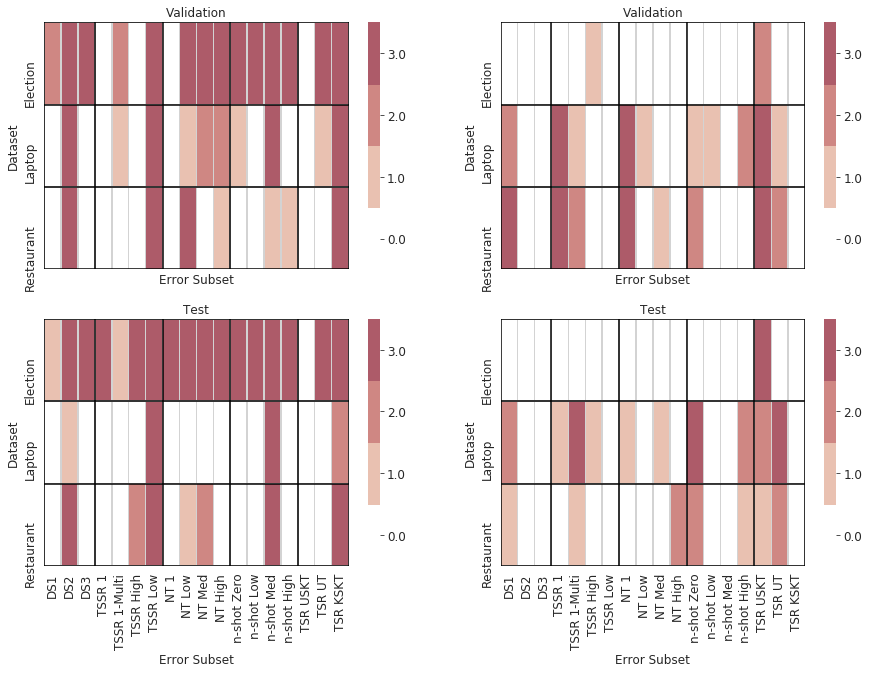

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(15,10), sharex=True)
# Plot the TDSA models better than CNN on the first column 
create_subset_heatmap(val_combined_error_subset_p_values_tdsa, 'P-Value', 
                      p_value_count(0.05), font_label_size=12, ax=axs[0][0])
axs[0][0].set_title('Validation')
create_subset_heatmap(test_combined_error_subset_p_values_tdsa, 'P-Value', 
                      p_value_count(0.05), font_label_size=12, ax=axs[1][0])
axs[1][0].set_title('Test')
# Plot the CNN model better than the TDSA models on the second column
create_subset_heatmap(val_combined_error_subset_p_values_cnn, 'P-Value', 
                      p_value_count(0.05), font_label_size=12, ax=axs[0][1])
axs[0][1].set_title('Validation')
create_subset_heatmap(test_combined_error_subset_p_values_cnn, 'P-Value', 
                      p_value_count(0.05), font_label_size=12, ax=axs[1][1])
_ = axs[1][1].set_title('Test')

To further ensure empirical rigour below we plot in the first column the number of TDSA models that are statistically significantly better than the text classification model across all datasets. Plots in the second column show the opposite, the number of TDSA models where the text classification is statistically significantly better. All plots have a confidence level of 95% ($p \leq 0.05$) and have been corrected using Bonferroni.

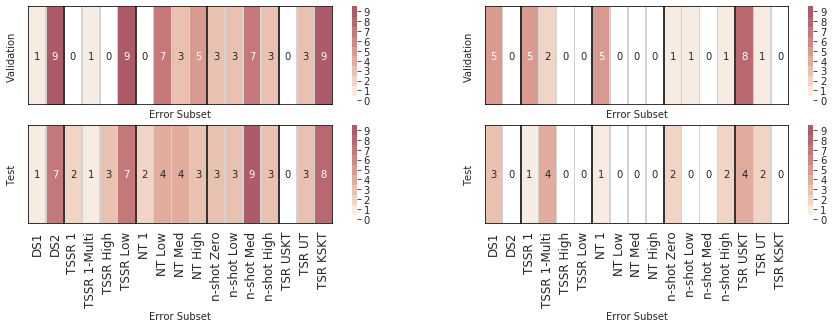

In [ ]:
alpha = 0.05

fig, axs = plt.subplots(2,2, figsize=(15,4), sharex=True)
column_index = 0
row_index = 0
for better_than_model, test_val_df in [('TDSA', combined_error_subset_p_values_tdsa),
                                       ('CNN', combined_error_subset_p_values_cnn)]:
  for split_name in ['Test', 'Validation']:
    if split_name == 'Test':
      row_index = 1
    else:
      row_index = 0

    error_split_names = []
    error_subset_names = []
    number_p_values = []
    dataset_split_names = []
    better_than_model_names = []  
    
    split_df = test_val_df[test_val_df['Split']==split_name]
    error_splits = split_df['Error Split'].unique().tolist()
    for error_split in error_splits:
      error_split_data_df = split_df[split_df['Error Split']==error_split]
      error_subsets = error_split_data_df['Error Subset'].unique().tolist()
      for error_subset in error_subsets:
        if error_subset == 'DS3':
          continue
        error_subset_df = error_split_data_df[error_split_data_df['Error Subset'] == error_subset]
        p_value_correction = find_k_estimator(error_subset_df['P-Value'], 
                                              alpha=alpha, method='B')
        error_split_names.append(error_split)
        error_subset_names.append(error_subset)
        number_p_values.append(p_value_correction)
        dataset_split_names.append(split_name)
        better_than_model_names.append(better_than_model)
    temp_df = pd.DataFrame({'Dataset': dataset_split_names, 
                            'Error Split': error_split_names, 
                            'Error Subset': error_subset_names, 
                            'Corrected P-Value': number_p_values})
    ax = axs[row_index][column_index]
    create_subset_heatmap(temp_df, 'Corrected P-Value', np.sum, 
                          heatmap_kwargs={'annot': True}, lines=True, 
                          vertical_lines_index=[0,2,6,10,14,17], 
                          horizontal_lines_index=[0,1], ax=ax, 
                          value_range=list(range(10)))
    ax.set_yticklabels([''])
    ax.set_ylabel(split_name)
  column_index += 1

To note in the heatmap directly above the $DS_3$ subset has been removed as the Laptop and Restaurant dataset do not contain enough samples within that subset. This also explains why in the other heatmap $DS_3$ subset for Laptop and Restaurant is 0 (white) as the p-values where not calculated for the same reason.

From all of these figures it is clear to see that the subsets that the TDSA models outperform the text classification model in are $DS_2$, $DS_3$, *low-TSSR*, *TSR KSKT*, *n-shot Med*, and *NT Low*. There are other subsets where the difference is significant as shown in the heatmaps but the majority of these significant differences only occur because of the Election dataset. Furthermore the outliers in these differences are the *n-shot Med*, and *NT Low* subsets of which the reason why it is believed these are outliers is due to the fact that both of these subsets are based on target information which the text classifier is explictly not using. The $DS_2$, $DS_3$, and the *low-TSSR* are expected to perform better for the TDSA models as they contain multiple unique sentiments within a sentence, for which a text
classification model can only predict one of those sentiments for the sentence
thus limiting the models capability to perform well on these subsets. This
therefore shows that the TDSA models must be learning some target sentiment relationship model or else they would not be more competitive than
the text classifier. The *TSR KSKT* shows that when the TDSA models
have seen a target enough times in a known sentiment context then they
can perform a lot better than the text classification model and there respective overall accuracy. However it is the other subsets within *TSR* that are of more interest showing the deficiencies of the TDSA models. The worse
subset within *TSR* is the *USKT* of which this is the only subset where the
text classification model in general perform significantly better. TDSA models are most likely biasing the target representation towards a subset of sentiment classes for those targets and hence why the text classification models perform better on those targets. The *UT* (*n-shot zero* is the same subset) subset is an interesting result as it is dataset dependent, in the Election dataset the TDSA models are better but in all other datasets the text classification model is better. This is most likely due to the size of the datasets as the Election dataset is much larger than the rest (the dataset size of all of the datasets can be seen below) and therefore could allow the TDSA models to create better general target representations, thus allowing the model to leverage similarities with known targets. From the heatmap it can be easily seen that on the Election dataset almost all subset are statistically significant compared to the Laptop and Restaurant dataset. This is most likely due to the Election dataset containing more targets per text and therefore far fewer texts within DS1 which is the subset the text classification model is most suited to. Even though the text classifier does not perform statistically significantly better than all the TDSA models on the Laptop and Restaurant datasets for DS1 they are never worse. Furthermore as the Laptop and Restaurant datasets are mainly made up of DS1 samples this is most likely the reason why the TDSA models are not statistically significantly better than the text classification models on these datasets.

In [ ]:
# Download the original splits for the election, laptop, restaurant datasets
import tempfile
from pathlib import Path
from collections import defaultdict

from target_extraction.data_types import TargetTextCollection
from target_extraction.analysis.dataset_statistics import dataset_target_sentiment_statistics
import requests 

original_datasets = defaultdict(dict)
download_dir = "https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/"
dataset_names = ['laptop', 'election', 'restaurant']
splits = ['train', 'val', 'test']

for dataset_name in dataset_names:
  for split in splits:
    download_url = f'{download_dir}{dataset_name}_dataset/{split}.json'
    response = requests.get(download_url, stream=True)
    with tempfile.TemporaryDirectory() as temp_dir:
      temp_file = Path(temp_dir, 'temp_file')
      with temp_file.open('wb+') as data_fp:
        for chunk in response.iter_content(chunk_size=128):
          data_fp.write(chunk)
      dataset = TargetTextCollection.load_json(temp_file)
      dataset.anonymised = True
      dataset.name = f'{dataset_name.capitalize()} {split}'
      original_datasets[f'{dataset_name}'][f'{split}'] = dataset

# Combine the splits
get_datasets = lambda name: [dataset for split, dataset in original_datasets[name].items()]

election_datasets = get_datasets('election')
combined_election = TargetTextCollection.combine(*election_datasets)
combined_election.name = 'Election'

laptop_datasets = get_datasets('laptop')
combined_laptop = TargetTextCollection.combine(*laptop_datasets)
combined_laptop.name = 'Laptop'

restaurant_datasets = get_datasets('restaurant')
combined_restaurant = TargetTextCollection.combine(*restaurant_datasets)
combined_restaurant.name = 'Restaurant' 

all_combined_datasets = [combined_laptop, combined_restaurant, combined_election]
dataset_target_sentiment_statistics(all_combined_datasets, dataframe_format=True)

,Name,No. Sentences,No. Sentences(t),No. Targets,No. Uniq Targets,ATS,ATS(t),TL 1 %,TL 2 %,TL 3+ %,Mean Sentence Length,Mean Sentence Length(t),POS (%),NEU (%),NEG (%)
0,Laptop,1872,1872,2950,1181,1.58,1.58,61.12,28.00,10.88,18.92,18.92,1328 (45.02),628 (21.29),994 (33.69)
1,Restaurant,2578,2578,4722,1528,1.83,1.83,74.21,16.75,9.04,17.20,17.20,2892 (61.25),829 (17.56),1001 (21.2)
2,Election,4045,4045,11899,2179,2.94,2.94,81.53,16.28,2.19,26.32,26.32,1744 (14.66),4572 (38.42),5583 (46.92)


Statistics for all of the Training, Validation, and Test splits combined for each dataset above. Below is the dataset statistics for each split for all datasets:

Details of what some of the columns mean:
* No. Sentences -- number of sentences in the collection
* No. Sentences(t) -- number of sentence that contain targets.
* No. Targets -- number of targets
* No. Uniq Targets -- number of unique targets
* ATS -- Average Target per Sentence (ATS)
* ATS(t) -- ATS but where all sentences in the collection must contain at least one target.
* TL (1) -- Percentage of targets that are length 1 based on the number of tokens.
* TL (2) -- Percentage of targets that are length 2 based on the number of tokens.
* TL (3+) -- Percentage of targets that are length 3+ based on the number of tokens.
* Mean Sent L -- Mean sentence length based on the tokens provided by the `tokenized_text` key in each TargetText within the collections. If this key does not exist then the collection will be tokenized using the given tokeniser argument.
* Mean Sent L(t) -- `Mean Sent L` but where all sentences in the collection must contain at least one target.
* POS (%) -- Number (Percentage) of positive targets
* NEU (%) -- Number (Percentage) of neutral targets
* NEG (%) -- Number (Percentage) of Negative targets

In [ ]:
all_split_data = [data for split_data in original_datasets.values() 
                  for data in split_data.values()]
dataset_target_sentiment_statistics(all_split_data, dataframe_format=True)

,Name,No. Sentences,No. Sentences(t),No. Targets,No. Uniq Targets,ATS,ATS(t),TL 1 %,TL 2 %,TL 3+ %,Mean Sentence Length,Mean Sentence Length(t),POS (%),NEU (%),NEG (%)
0,Laptop train,1051,1051,1661,739,1.58,1.58,62.67,26.79,10.54,19.95,19.95,695 (41.84),319 (19.21),647 (38.95)
1,Laptop val,411,411,652,368,1.59,1.59,63.34,27.61,9.05,19.12,19.12,292 (44.79),141 (21.63),219 (33.59)
2,Laptop test,411,411,638,389,1.55,1.55,54.86,31.50,13.64,16.09,16.09,341 (53.45),169 (26.49),128 (20.06)
3,Election train,2319,2319,6811,1496,2.94,2.94,81.76,16.00,2.23,26.31,26.31,1014 (14.89),2645 (38.83),3152 (46.28)
4,Election val,863,863,2547,741,2.95,2.95,81.98,15.94,2.08,26.28,26.28,352 (13.82),970 (38.08),1225 (48.1)
5,Election test,863,863,2541,751,2.94,2.94,80.44,17.36,2.20,26.37,26.37,378 (14.88),957 (37.66),1206 (47.46)
6,Restaurant train,1378,1378,2490,914,1.81,1.81,74.34,16.63,9.04,17.17,17.17,1489 (59.8),422 (16.95),579 (23.25)
7,Restaurant val,600,600,1112,480,1.85,1.85,76.89,15.47,7.64,17.89,17.89,675 (60.7),211 (18.97),226 (20.32)
8,Restaurant test,600,600,1120,520,1.87,1.87,71.25,18.30,10.45,16.58,16.58,728 (65.0),196 (17.5),196 (17.5)


## Exploring why the *NT* split does not show a consistent trend
As stated earlier the *NT* split does not show any type of consistent trend. This can be seen easily in the absolute error subset figures. A reason for this could be that there are other factors that influence this split. The factors that will be explored are the target sentiment relationship factors which can be measured to some extent using the *DS* and *TSSR* splits. Below we shall plot the accuracy scores for the *NT* subsets when they have been first subsetted by *DS* and *TSSR* first. To do so we have to first download the raw results data and process it so that we have a DataFrame that contains the following (and a few more columns that are not essential):
1. Subset By: This is either a subset of *DS* or *TSSR*. This states what subset has been used to subset the data before subsetting it further by one of the *NT* subsets.
2. Reduced Error Split: This is either *DS* or *TSSR* and stated if the subset comes from either the *DS* or *TSSR* split.
3. NT: This will be one of the *NT* subsets (It will be the shorthand name for the subset).
4. Accuracy: The accuracy value associated to the *NT* subset after being subsetted by the *Subset By*.
5. Dataset: The dataset this analysis is performed on. Either Election, Laptop, or Restaurant.
6. Dataset Size: Size of the *NT* subset after being subsetted by *Subset By*.
7. Model: The model that produced the *Accuracy* score.

(**NOTE: Generating the results below can take a long time (10-15 minutes) and is dependent on the number of CPUs**. However due to this it is not required that you generate the results here as the results have already been created and are saved at the following [URL](https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/nt_subset_results.tsv) but the code to produce those results is shown below as an example of how to generate such results)


In [ ]:
from collections import defaultdict
import tempfile
from pathlib import Path

import requests

from target_extraction.data_types import TargetTextCollection
from target_extraction.analysis.sentiment_error_analysis import (error_analysis_wrapper, 
                                                                 error_split_df)
from target_extraction.analysis.util import add_metadata_to_df
from target_extraction.analysis.sentiment_metrics import accuracy

# Change this to True if you would like to process the results here rather than download 
# them. This can take a while to generate the results.
generating_results = False
if generating_results:
  tssr_func = error_analysis_wrapper('TSSR')
  ds_func = error_analysis_wrapper('DS')
  nt_func = error_analysis_wrapper('NT')
  all_relevant_error_funcs = [tssr_func, ds_func, nt_func]

  splits = ['test', 'val']
  dataset_names = ['Laptop', 'Restaurant', 'Election']
  download_dir_url = f'https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/'

  all_dfs = []
  relevant_prediction_keys = overall_results['prediction key'].unique().tolist()
  nt_error_names = ERROR_SPLIT_SUBSET_NAMES['NT']
  ds_error_names = ERROR_SPLIT_SUBSET_NAMES['DS']
  tssr_error_names = ERROR_SPLIT_SUBSET_NAMES['TSSR']
  reduced_collection_subset_names = ds_error_names + tssr_error_names
  nt_split_subsets = {'NT': ERROR_SPLIT_SUBSET_NAMES['NT']}

  for dataset_name in dataset_names:
    for split in splits:
      download_url = download_dir_url + f'{dataset_name.lower()}_dataset/{split}.json'
      response = requests.get(download_url, stream=True)
      with tempfile.TemporaryDirectory() as temp_dir:
        temp_file = Path(temp_dir, 'temp_file')
        with temp_file.open('wb+') as data_fp:
          for chunk in response.iter_content(chunk_size=128):
            data_fp.write(chunk)
        dataset = TargetTextCollection.load_json(temp_file)
        for error_func in all_relevant_error_funcs:
          error_func(None, dataset, True)
        for reduced_collection_subset_name in reduced_collection_subset_names:
          temp_df = error_split_df(None, dataset, relevant_prediction_keys, 
                                  'target_sentiments', nt_split_subsets, accuracy,
                                  {'ignore_label_differences': True}, 
                                  include_dataset_size=True,
                                  collection_subsetting=[[reduced_collection_subset_name]],
                                  table_format_return=False)
          temp_df = add_metadata_to_df(temp_df, dataset, 
                                      'predicted_target_sentiment_key')
          temp_df['reduced collection subset'] = reduced_collection_subset_name
          temp_df['Dataset'] = dataset_name
          temp_df['Split'] = split.capitalize()
          all_dfs.append(temp_df)
  all_dfs = pd.concat(all_dfs, 0, ignore_index=True)
  temp_dfs = all_dfs.copy(deep=True)
  all_subset_names = [name for subset_names in ERROR_SPLIT_SUBSET_NAMES.values() 
                      for name in subset_names]
  temp_dfs['Reduced Error Split'] = temp_dfs.apply(lambda x: subset_name_to_error_split(x['reduced collection subset']), 1)
  temp_dfs['Metric'] = temp_dfs['Metric'] * 100
  temp_dfs = temp_dfs.rename(columns={'Metric': 'Accuracy'})
  temp_dfs['NT'] = temp_dfs.apply(lambda x: PLOT_SUBSET_ABBREVIATION[x['subset names']], 1)
  temp_dfs['Subset By'] = temp_dfs.apply(lambda x: PLOT_SUBSET_ABBREVIATION[x['reduced collection subset']], 1)
  temp_dfs = temp_dfs.drop(columns=['reduced collection subset', 'subset names'])
else:
  temp_dfs = pd.read_csv('https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/nt_subset_results.tsv',
                         sep='\t')
  temp_dfs = temp_dfs.drop(columns=['Unnamed: 0'])

# Remove all that have zero accuracy
temp_dfs = temp_dfs[temp_dfs['Accuracy']!=0]

# Filter by validation and test splits
validation_temp_dfs = temp_dfs[temp_dfs['Split']=='Val']
test_temp_dfs = temp_dfs[temp_dfs['Split']=='Test']
# Filter by DS and TSSR subsets
ds_validation_temp_dfs = validation_temp_dfs[validation_temp_dfs['Reduced Error Split']=='DS']
ds_test_temp_dfs = test_temp_dfs[test_temp_dfs['Reduced Error Split']=='DS']

tssr_validation_temp_dfs = validation_temp_dfs[validation_temp_dfs['Reduced Error Split']=='TSSR']
tssr_test_temp_dfs = test_temp_dfs[test_temp_dfs['Reduced Error Split']=='TSSR']

temp_dfs

,prediction key,run number,Accuracy,Dataset Size,Model,Inter-Aspect,CWR,Position,Dataset,Split,Reduced Error Split,NT,Subset By
0,predicted_target_sentiment_AE_GloVe_None_None,0,65.637066,259,AE,False,False,False,Laptop,Test,DS,1,DS1
1,predicted_target_sentiment_AE_GloVe_None_None,1,64.864865,259,AE,False,False,False,Laptop,Test,DS,1,DS1
2,predicted_target_sentiment_AE_GloVe_None_None,2,67.181467,259,AE,False,False,False,Laptop,Test,DS,1,DS1
3,predicted_target_sentiment_AE_GloVe_None_None,3,67.181467,259,AE,False,False,False,Laptop,Test,DS,1,DS1
4,predicted_target_sentiment_AE_GloVe_None_None,4,65.637066,259,AE,False,False,False,Laptop,Test,DS,1,DS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,predicted_target_sentiment_TDLSTM_GloVe_None_None,3,61.654135,266,TDLSTM,False,False,False,Election,Val,TSSR,High,High
3720,predicted_target_sentiment_TDLSTM_GloVe_None_None,4,60.150376,266,TDLSTM,False,False,False,Election,Val,TSSR,High,High
3721,predicted_target_sentiment_TDLSTM_GloVe_None_None,5,59.398496,266,TDLSTM,False,False,False,Election,Val,TSSR,High,High
3722,predicted_target_sentiment_TDLSTM_GloVe_None_None,6,65.789474,266,TDLSTM,False,False,False,Election,Val,TSSR,High,High


### Plotting the performance of NT subsets factoring in the DS subsets

Below we plot the performance of all models after the data has been subsetted by a *DS* subset and then further subsetted by one of the *NT* subsets. This will therefore show how the *DS* subsets affect the *NT* subsets. We show below first the performance on the validation data and then the test:

Validation: 

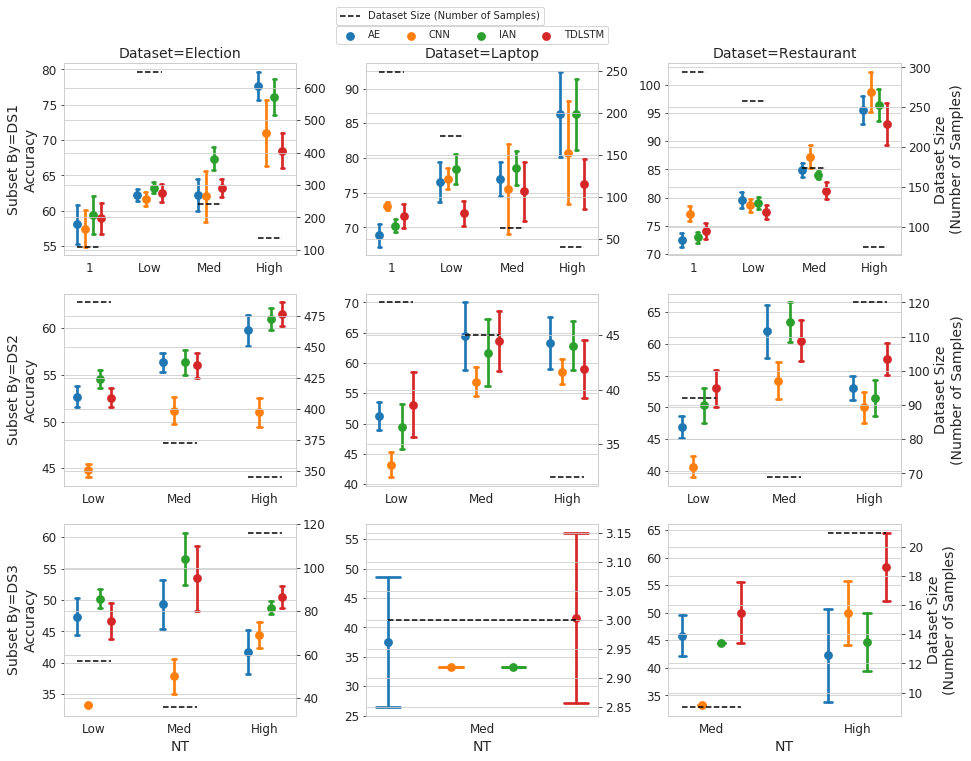

In [ ]:
DS_ORDER = ['DS1', 'DS2', 'DS3']
_ = plot_error_subsets(ds_validation_temp_dfs, 'Dataset', 'Subset By', 
                       'NT', 'Accuracy', 'Model', df_dataset_size='Dataset Size',
                       legend_column=1, row_order=DS_ORDER,
                       column_order=DATASET_COLUMN_ORDER)


Test:

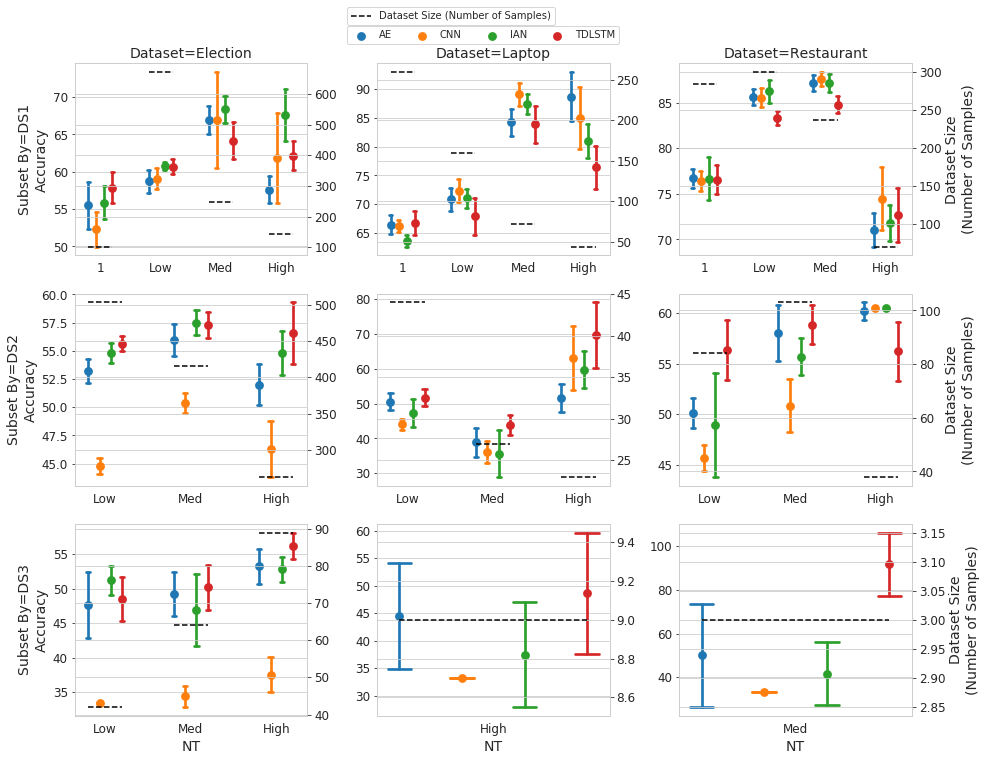

In [ ]:
_ = plot_error_subsets(ds_test_temp_dfs, 'Dataset', 'Subset By', 
                       'NT', 'Accuracy', 'Model', df_dataset_size='Dataset Size',
                       legend_column=1, row_order=DS_ORDER,
                       column_order=DATASET_COLUMN_ORDER)

Before going into the analysis we should first state that there are no $NT_1$ subsets for the plots in the $DS_2$ and $DS_3$ rows as this is not possible by defination of the subsets. Also for the Laptop and Restaurant datasets the $DS_3$ row does not have many samples as these datasets do not contains many $DS_3$ samples thus those results should be ignored but are shown for transparency. The analysis for the *DS* subset data will be done after showing the results from plotting *TSSR* results:

### Plotting the performance of NT subsets factoring in the TSSR subsets

Validation:

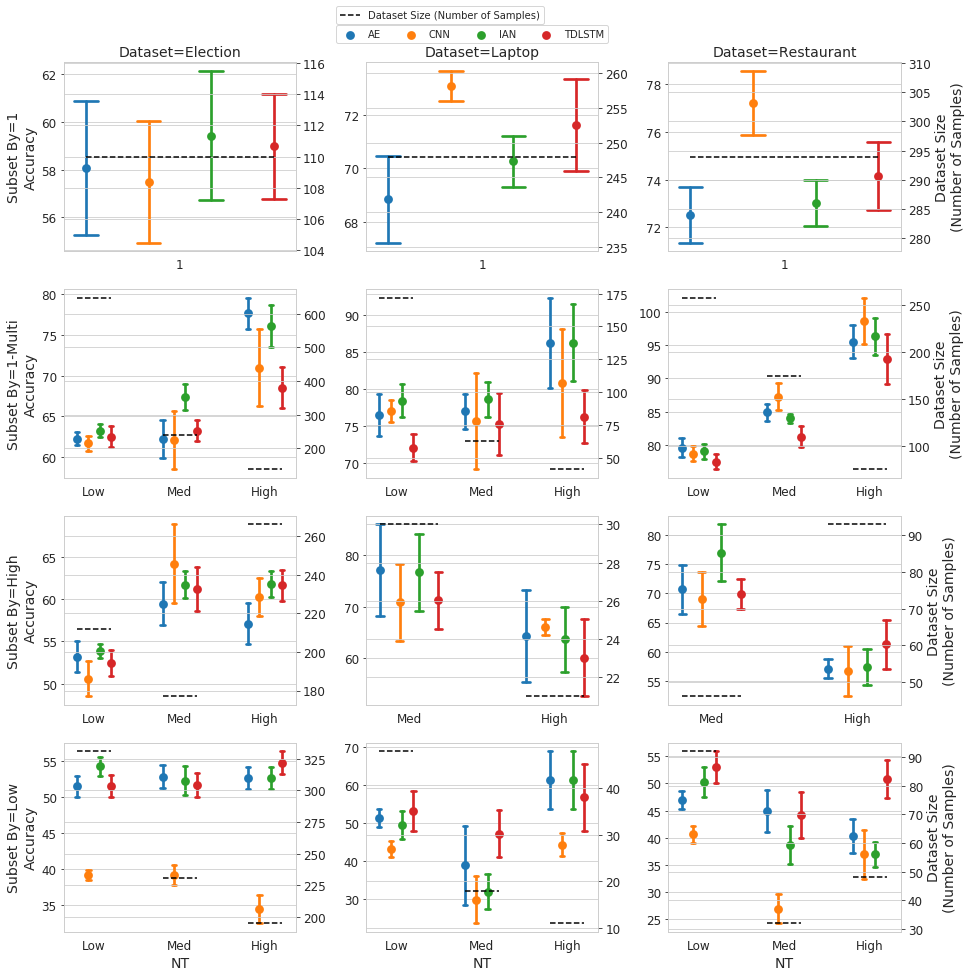

In [ ]:
TSSR_ORDER = ['1', '1-Multi', 'High', 'Low']
_ = plot_error_subsets(tssr_validation_temp_dfs, 'Dataset', 'Subset By', 
                       'NT', 'Accuracy', 'Model', df_dataset_size='Dataset Size',
                       legend_column=1, row_order=TSSR_ORDER,
                       column_order=DATASET_COLUMN_ORDER)

Test:

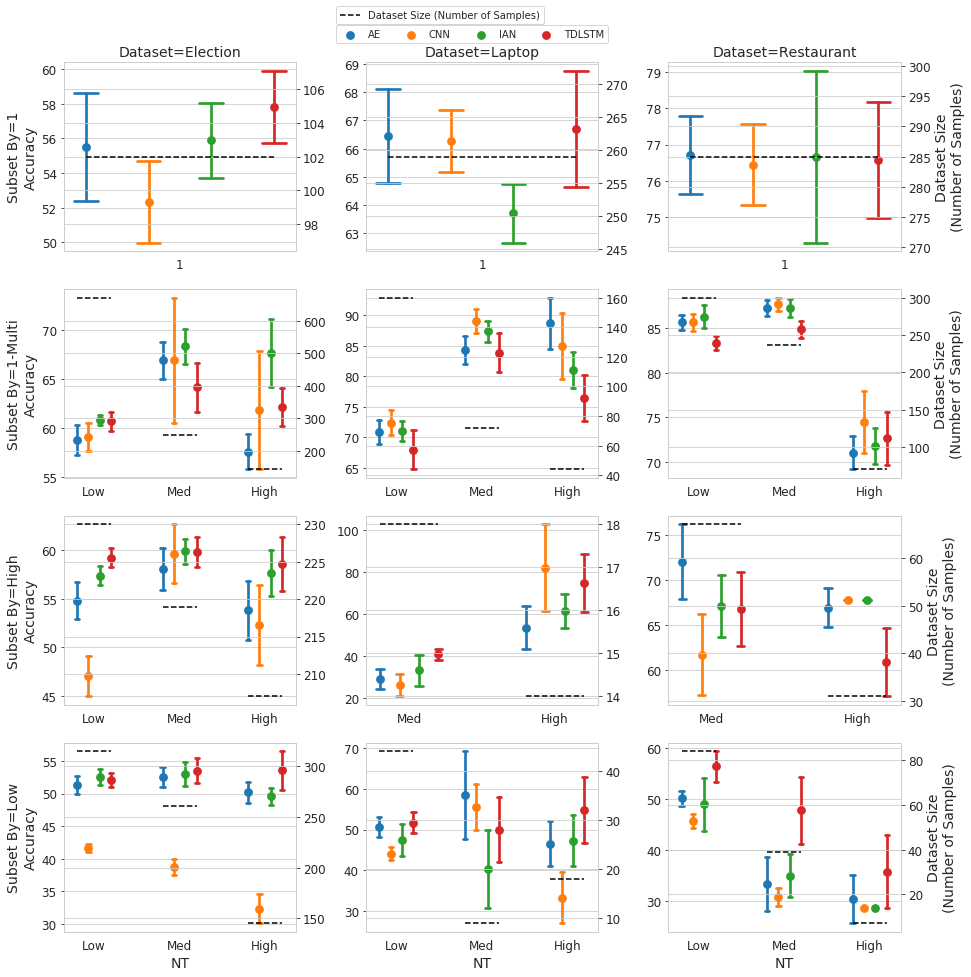

In [ ]:
_ = plot_error_subsets(tssr_test_temp_dfs, 'Dataset', 'Subset By', 
                       'NT', 'Accuracy', 'Model', df_dataset_size='Dataset Size',
                       legend_column=1, row_order=TSSR_ORDER,
                       column_order=DATASET_COLUMN_ORDER)

Before going into the analysis for both the *DS* and *TSSR* results above. The *1* row for the *TSSR* subsets only contain the *1* *NT* subset due to the defination of the subsets. However left here again for transparency.

From analysing the *DS* and *TSSR* figures we can see that in general for the $DS_1$ and *TSSR 1-Multi* rows the longer the sentence (larger *NT*) the better the performance of the models, of which for $DS_1$ row this can be better seen in the validation split than the test. This is most likely the case because of the models exploiting the fact that there are more targets expressing the same sentiment. This exploitation of targets expressing the same sentiment can also be seen in the $DS_2$ rows (better seen in the validation data) where the more targets the better the score. 

Within the *Low* and *High TSSR* subsets the trend is less clear. The expectation within these subsets would be, the *Low (High) TSSR* subset that when there are more (less) targets (higher *NT*) the worse the results. This expectation is under the assumption that the more targets in *High (Low) TSSR* subset the more (less) targets that have the same sentiment and thus exploiting the most frequent sentiment would gain a higher (lower) accuracy score. However this expectation is not always true and can be in-consistent between splits for example the *High TSSR* Laptop results have differenct trends between test and validation splits. Furthermore this assumption of more targets within the *TSSR Low* and *High* subsets does not necessarily mean more targets of the most frequent sentiment class due to the way *TSSR* subsets are created hence a potential reason why there is no consistent correlations in those subsets. Thus this analysis shows to some extent why the *NT* split has no trend as the target sentiment relationship factors are more influential than the number of targets on the performance of the models. This therefore solves to some extent why [Zhang et al. (2019)](https://www.aclweb.org/anthology/D19-1464.pdf) also could not find a steady trend for the *NT* split.

### Why the *DS* split is not consistent over different metrics

Even through the $DS_i$ split was stated to get more difficult as $i$ increased and has been shown in original work to be true ([Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046/)), it has also been shown in the same work not to be true when either the method and or metric changes (see table 4 in [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046/)). Therefore here we are going to invetigate why some of the methods in [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046/) performed better in the $DS_3$ split compared to $DS_1$ or $DS_2$ for the macro F1 metric on the Election dataset. As we have already shown when using the Accuracy metric all methods on all datasets always perform worse on $DS_i$ subsets when $i$ increases. First we are going to see if the models tested here create the same findings as [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046/).

Load the macro F1 data:


In [ ]:
from target_extraction.analysis.sentiment_error_analysis import (ERROR_SPLIT_SUBSET_NAMES,
                                                                 PLOT_SUBSET_ABBREVIATION,
                                                                 subset_name_to_error_split)

import pandas as pd
macro_f1_results = pd.read_csv('https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/macro_f1_results.tsv', sep='\t')
macro_f1_results = macro_f1_results.replace({'Model': 'AE'}, 'Att-AE')

all_subset_names = [name for subset_names in ERROR_SPLIT_SUBSET_NAMES.values() 
                    for name in subset_names]
macro_f1_results = long_format_metrics(macro_f1_results, all_subset_names)
macro_f1_results['Error Split'] = macro_f1_results.apply(lambda x: subset_name_to_error_split(x['Metric']), 1)
macro_f1_results['Macro F1'] = macro_f1_results['Metric Score'] * 100
macro_f1_results = macro_f1_results.rename(columns={'Metric': 'Error Subset'})
macro_f1_results['Error Subset'] = macro_f1_results.apply(lambda x: PLOT_SUBSET_ABBREVIATION[x['Error Subset']], 1)
macro_f1_results = macro_f1_results.drop(columns=['Metric Score'])

column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': False}
macro_f1_subset_results = filter_df(macro_f1_results, column_values)

macro_f1_subset_results = macro_f1_subset_results[~((macro_f1_subset_results['Error Subset']=='DS3')&
                                                    (macro_f1_subset_results['Dataset']!='Election'))]
macro_f1_ds_results = macro_f1_subset_results[macro_f1_subset_results['Error Subset'].isin(['DS1', 'DS2', 'DS3'])]
macro_f1_ds_results['DS Subset']=macro_f1_ds_results['Error Subset']

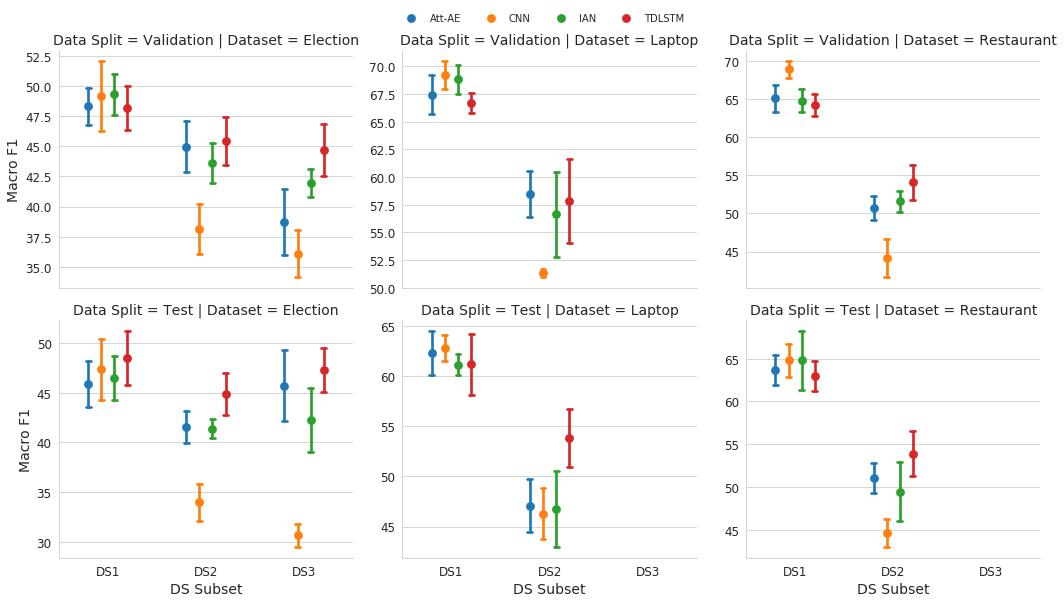

In [ ]:
cat_plot = sns.catplot(kind='point', col='Dataset', row='Data Split', x='DS Subset', 
                       y='Macro F1', hue='Model', data=macro_f1_ds_results, 
                       join=False, dodge=0.4, capsize=0.05, ci='sd', sharey=False,
                       row_order=SPLIT_ORDER, col_order=DATASET_COLUMN_ORDER,
                       legend=False)
cat_plot.fig.set_size_inches(15,8)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, bbox_to_anchor=(0.29, 1))

As we can see from the results above the only dataset that follows the same trend as [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046/) is the Election test dataset, which is the dataset [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046/) evaluated on. The Laptop, Restaurant, and Election validation datasets follow the same trend as the the accuracy results reported earlier for the *DS* split.

As the macro F1 metric is not biased by the un-balanced label distribution that is within any dataset compared to the accuracy metric. This suggests that the reason for the unusual trend in the Election test *DS* results requires inspecting the F1 results for each of the sentiment labels.


(To look at the results for each of the sentiment labels requires downloading the original data that contains all of the raw prediction results and gold labels)

In [ ]:
# Download the original splits for the election, laptop, restaurant datasets
import tempfile
from pathlib import Path
from collections import defaultdict

from target_extraction.data_types import TargetTextCollection
import requests 
original_datasets = defaultdict(dict)
download_dir = "https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/"
dataset_names = ['laptop', 'election', 'restaurant']
splits = ['train', 'val', 'test']
for dataset_name in dataset_names:
  for split in splits:
    download_url = f'{download_dir}{dataset_name}_dataset/{split}.json'
    response = requests.get(download_url, stream=True)
    with tempfile.TemporaryDirectory() as temp_dir:
      temp_file = Path(temp_dir, 'temp_file')
      with temp_file.open('wb+') as data_fp:
        for chunk in response.iter_content(chunk_size=128):
          data_fp.write(chunk)
      dataset = TargetTextCollection.load_json(temp_file)
      dataset.name = f'{dataset_name.capitalize()} {split}'
      original_datasets[f'{dataset_name}'][f'{split}'] = dataset

In [ ]:
from target_extraction.analysis.util import add_metadata_to_df, long_format_metrics
from target_extraction.analysis.sentiment_error_analysis import ERROR_SPLIT_SUBSET_NAMES, error_split_df
from target_extraction.analysis.sentiment_metrics import macro_f1

ds_subsets = ['distinct_sentiment_1','distinct_sentiment_2', 
              'distinct_sentiment_3']
relevent_prediction_keys = overall_test_results['prediction key'].unique().tolist()
split_all_sentiments = []
for dataset_name in dataset_names:
  for test_name in ['val', 'test']:
    temp_ds_subsets = ds_subsets[:-1]
    if dataset_name == 'election':
      temp_ds_subsets = ds_subsets
    ds_dict_subsets = {'DS': temp_ds_subsets}

    relevent_datasets = original_datasets[dataset_name]
    pos = error_split_df(relevent_datasets['train'], relevent_datasets[test_name], 
                        relevent_prediction_keys, 'target_sentiments', 
                        ds_dict_subsets, macro_f1, {'labels': ['positive']})
    pos = pos.reset_index().set_index(['prediction key', 'run number'])
    pos['Sentiment'] = 'Positive'
    pos['Split'] = 'Test' if test_name == 'test' else 'Validation'
    neg = error_split_df(relevent_datasets['train'], relevent_datasets[test_name], 
                        relevent_prediction_keys, 'target_sentiments', 
                        ds_dict_subsets, macro_f1, {'labels': ['negative']})
    neg = neg.reset_index().set_index(['prediction key', 'run number'])
    neg['Sentiment'] = 'Negative'
    neg['Split'] = 'Test' if test_name == 'test' else 'Validation'
    neu = error_split_df(relevent_datasets['train'], relevent_datasets[test_name], 
                        relevent_prediction_keys, 'target_sentiments', 
                        ds_dict_subsets, macro_f1, {'labels': ['neutral']})
    neu = neu.reset_index().set_index(['prediction key', 'run number'])
    neu['Sentiment'] = 'Neutral'
    neu['Split'] = 'Test' if test_name == 'test' else 'Validation'
    all_sentiment = pd.concat([pos, neg, neu], axis=0, sort=False).reset_index()
    add_metadata_to_df(all_sentiment, original_datasets['election']['test'], 
                      'predicted_target_sentiment_key')
    all_sentiment = long_format_metrics(all_sentiment, temp_ds_subsets)
    all_sentiment['Dataset'] = dataset_name.capitalize()
    split_all_sentiments.append(all_sentiment)
split_all_sentiments = pd.concat(split_all_sentiments, axis=0, 
                                 sort=False).reset_index()
ds_replace_dict = {'distinct_sentiment_1': 'DS1', 'distinct_sentiment_2': 'DS2', 
                   'distinct_sentiment_3': 'DS3'}
split_all_sentiments['Metric'] = split_all_sentiments['Metric'].replace(ds_replace_dict)
split_all_sentiments['DS Subset'] = split_all_sentiments['Metric']
split_all_sentiments['F1'] = split_all_sentiments['Metric Score'] * 100

As we can see below the F1 score for each sentiment is very different and as expected the most frequent sentiment (negative) has the highest scores no matter the subset. These results highlight why the macro F1 score does not have the same negative trend as the accuracy metric does for the *DS* split. As the results show the positive and the neutral sentiments do not follow the negative trend that the negative sentiment does. Thus as the scores of each sentiment are weighted the same in the macro F1 metric this therefore causes the macro F1 score for the $DS_3$ subset to be higher than the $DS_2$ subset in the test split. The potential reason for this unusual trend could be due to the model overfitting to the most frequent sentiment class (negative) and hence why if the model predict negative for all samples in a $DS_3$ sentence then it would get some samples correct but it would get at least 2 samples wrong. Below we also plot the same results for the Laptop and Restaurant datasets. From these two plots we can see that the most frequent sentiment class (positive for both datasets) has the largest drop in F1 score from $DS_1$ to $DS_2$. This large drop in F1 score gives some extra merit to the idea that the models are overfitting to the most frequent sentiment class. Due to this overfitting the model is most likely predicting the most frequent sentiment class more often than it should where as in the cases for the least frequent sentiment classes it could be only predicting these when it is confident. These reasons are not empirically proven but the results have shown further insight into the *DS* split. 

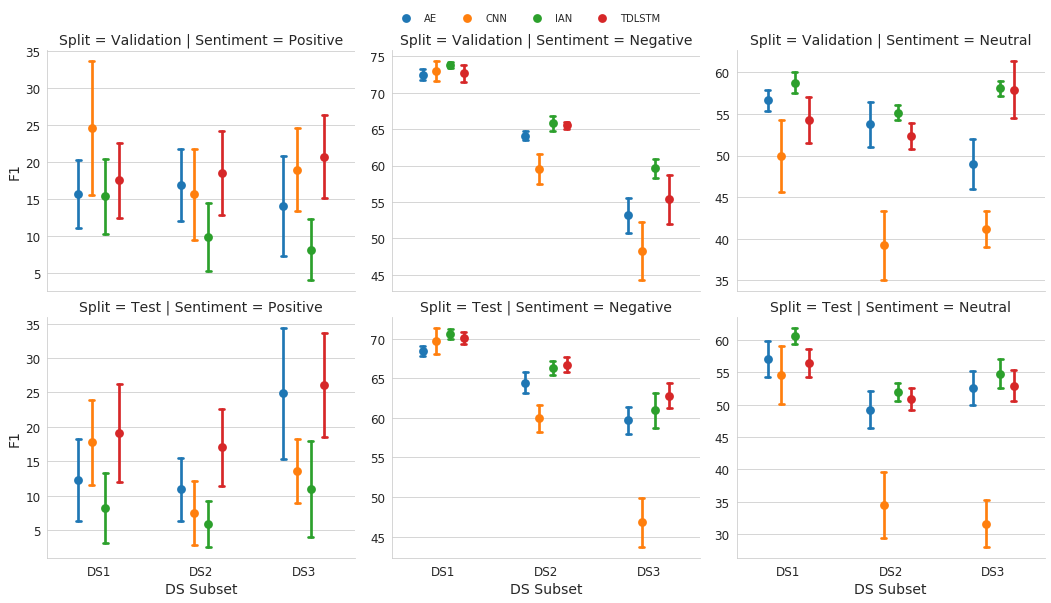

In [ ]:
election_split_all_sentiments = split_all_sentiments[split_all_sentiments['Dataset']=='Election']
cat_plot = sns.catplot(kind='point', x='DS Subset', hue='Model', y='F1', 
                       row='Split', col='Sentiment', data=election_split_all_sentiments,
                       ci='sd', join=False, dodge=0.4, sharey=False, capsize=0.05,
                       legend=False)
cat_plot.fig.set_size_inches(15,8)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, bbox_to_anchor=(0.29, 1))

Laptop results

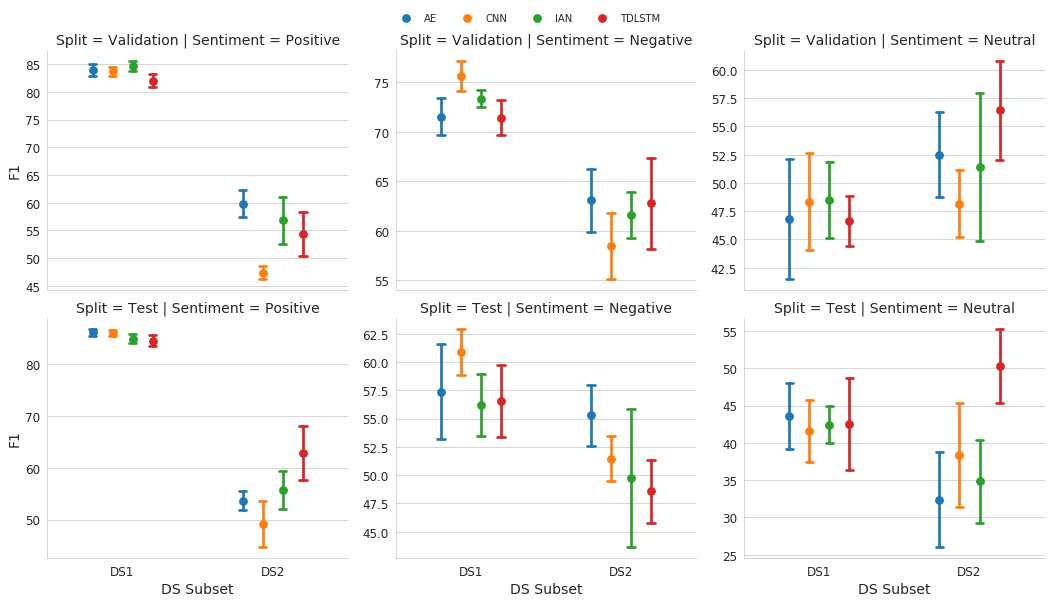

In [ ]:
laptop_split_all_sentiments = split_all_sentiments[split_all_sentiments['Dataset']=='Laptop']
cat_plot = sns.catplot(kind='point', x='DS Subset', hue='Model', y='F1', 
                       row='Split', col='Sentiment', data=laptop_split_all_sentiments,
                       ci='sd', join=False, dodge=0.4, capsize=0.05, sharey=False,
                       legend=False)
cat_plot.fig.set_size_inches(15,8)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, bbox_to_anchor=(0.29, 1))

Restaurant results

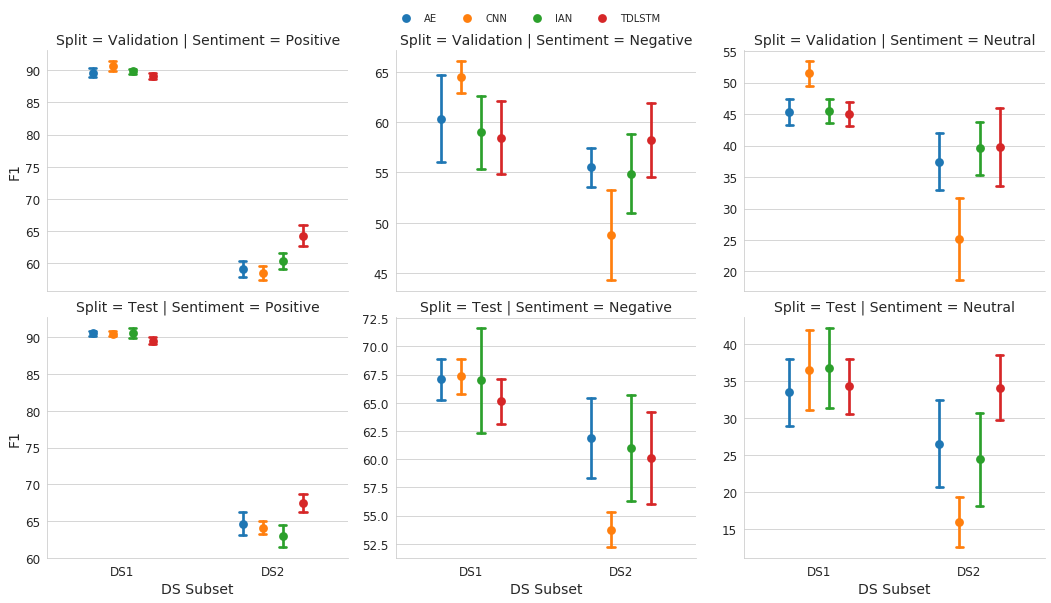

In [ ]:
restaurant_split_all_sentiments = split_all_sentiments[split_all_sentiments['Dataset']=='Restaurant']
cat_plot = sns.catplot(kind='point', x='DS Subset', hue='Model', y='F1', 
                       row='Split', col='Sentiment', data=restaurant_split_all_sentiments,
                       ci='sd', join=False, dodge=0.4, capsize=0.05, sharey=False,
                       legend=False)
cat_plot.fig.set_size_inches(15,8)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, bbox_to_anchor=(0.29, 1))

# New TDSA metric (STAC):
Both the *DS* and *TSSR* error splits explore the concepts of target sentiment relationships and overfitting to the most common sentiment within a text. However neither of these can create error subsets that will explictly inform you if the model can detect sentiment for all the targets in the text and thus performing the target sentiment relationships task perfectly. Both the $DS_3$ and *low-TSSR* subsets do perform this to some extent but both are subject to the model finding the most common or easiest to find sentiment for some/all of the targets in the subsets.


Thus the creation of the Strict Text ACcuracy (*STAC*) metric. This metric works on the sentence/text level compared to the accuracy and macro F1 metrics that are based at the target level. *STAC* treats each sentence as a sample and each sentence can only be correct if all targets within that sentence have been classified correctly, it is then averaged by the number of sentences. The *STAC* equation can be seen below along with *TAC* which finds the average number of targets that are correct within a sentence. $T_j$ within *STAC* represents all of the targets within sentence $j$ from all sentences $X$ that is within the dataset, and $t_{ji}$ represents target $i$ true sentiment within sentence $T_j$ where $\hat{t_{ji}}$ is the predicted sentiment.

$$\text{Text Accuracy (TAC)}(T_j) = \frac{\sum_{i=1}^{|T_j|} [t_{ji}=\hat{t_{ji}}]}{|T_j|}$$


$$
    \text{Strict Text Accuracy (STAC)} = \frac{\sum_{j=1}^{|X|} \begin{cases}
    1,& \text{if } \text{TAC}(T_j) = 1\\
    0,              & \text{otherwise}
\end{cases}}{|X|}
$$ 

Below we show the scores of three different version of STAC across all datasets and models along with the normal accuracy score. The different STAC versions are:
1. The normal STAC which uses the whole dataset
2. *STAC 1* only performs STAC on the $DS_1$ subset
3. *STAC Multi* only performs STAC on the combination of $DS_2$ and $DS_3$ subsets.

The reason for the different STACs is to show different model properties. The performance on the *STAC Multi* shows how well a model can perform target sentiment relation modelling as in this case it cannot exploit the fact that the sentence only contains one sentiment. The difference between *STAC 1* and *STAC Multi* can show to some degree how much the model is exploiting the fact the sentence only contains one sentiment.

Below is the validation and test results of the models across all of the datasets for all of the metrics:

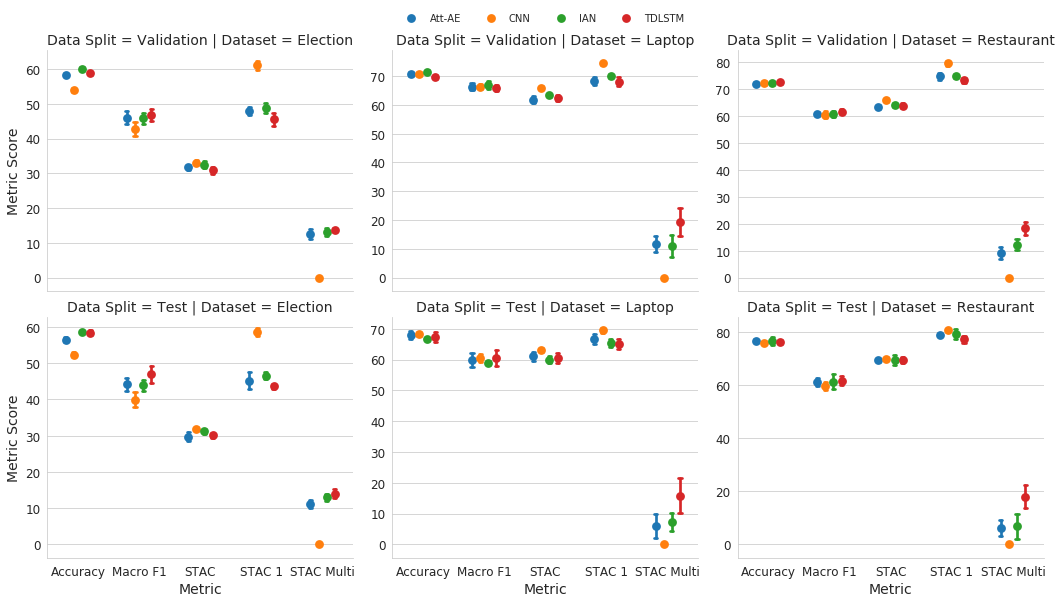

In [ ]:
stac_plotting_results = long_format_metrics(all_results, ['Accuracy', 'Macro F1', 'STAC', 'STAC 1', 'STAC Multi'])
stac_overall_plotting_results = filter_df(stac_plotting_results, column_values)
stac_overall_plotting_results['Metric Score'] = stac_overall_plotting_results['Metric Score'] * 100

cat_plot = sns.catplot(x='Metric', y='Metric Score',  data=stac_overall_plotting_results, 
                       kind='point', col='Dataset', ci='sd', join=False,
                       hue='Model' , sharey=False, row='Data Split',
                       row_order=SPLIT_ORDER, col_order=DATASET_COLUMN_ORDER,
                       dodge=0.4, capsize=0.05, legend=False)
cat_plot.fig.set_size_inches(15,8)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, bbox_to_anchor=(0.29, 1))

As can be seen from the plot *STAC Multi* is by far the most difficult metric and scores much lower than any of the accuracy metrics on any of the subsets shown in the plots above. However the *STAC 1* results can be the easiest metric as shown by the Restaurant dataset. The difference between *STAC 1* and *STAC Multi* for the TDSA models is rather large and more so for the Restaurant and Laptop datasets which could be due to the fact there are proportionally and overall more $DS_2$ and $DS_3$ sentences in Election than the Restaurant and Laptop datasets as shown by the table below. Furthermore as should be the case the text classification model (*CNN*) scores $0$ in all of the *STAC Multi* thus showing again the point of the metric and the relevancy to TDSA. These scores highlight that TDSA models have much to improve upon with regards to target sentiment relation modelling as shown by the *STAC Multi* metric without resorting to simpler majority sentiment classification of the sentence as shown by *STAC 1*, and the other error subsets ($DS_1$, *TSSR 1*, and *TSSR 1-Multi*). Furthermore from the results it is interesting to see that *TDLSTM* model generally performs well on the *STAC Multi* metric compared to the other models across all datasets, of which this could be due to the model encoding position of the target within it's architecture. 

In [ ]:
# Getting the number of DS_1, DS_2, and DS_3 sentences in all of the dataset 
# splits.
from target_extraction.analysis.sentiment_error_analysis import reduce_collection_by_key_occurrence
from target_extraction.analysis.sentiment_error_analysis import error_analysis_wrapper

dataset_names = []
split_names = []
DS_1_sentences = []
DS_2_3_sentences = []
total_sentences = []

for dataset_name, split_data in original_datasets.items():
  for split_name, data in split_data.items():
    dataset_names.append(dataset_name.capitalize())
    split_names.append(split_name.capitalize())
    data: TargetTextCollection
    total_sentences.append(len(data))
    ds_func = error_analysis_wrapper('DS')
    ds_func(None, data, True)
    ds_1_sentences = len(reduce_collection_by_key_occurrence(data, 
                                                             ['distinct_sentiment_1'], 
                                                             ['targets', 'spans']))
    ds_23_sentences = len(reduce_collection_by_key_occurrence(data, 
                                                              ['distinct_sentiment_2', 
                                                               'distinct_sentiment_3'], 
                                                              ['targets', 'spans']))
    DS_1_sentences.append(ds_1_sentences)
    DS_2_3_sentences.append(ds_23_sentences)
ds_sentence_stats = {'Dataset': dataset_names, 'Split': split_names,
                     'Total Sentences': total_sentences, 
                     'DS 1 Sentences': DS_1_sentences,
                     'DS 2 and 3 Sentences': DS_2_3_sentences}
ds_sentence_stats = pd.DataFrame(ds_sentence_stats)

pd.pivot_table(ds_sentence_stats, columns='Split', index = 'Dataset', 
               values=['Total Sentences', 'DS 1 Sentences', 'DS 2 and 3 Sentences'], 
               aggfunc=np.mean).T


Dataset                     Election  Laptop  Restaurant
                     Split                              
DS 1 Sentences       Test        469     373         520
                     Train      1227     933        1162
                     Val         467     364         497
DS 2 and 3 Sentences Test        394      38          80
                     Train      1092     118         216
                     Val         396      47         103
Total Sentences      Test        863     411         600
                     Train      2319    1051        1378
                     Val         863     411         600

In [ ]:
pd.pivot_table(overall_validation_results, index='Model', columns='Dataset', 
               values=['STAC', 'STAC 1', 'STAC Multi', 'Accuracy'], 
               aggfunc=mean_std).T

Model                        Att-AE           CNN           IAN        TDLSTM
           Dataset                                                           
Accuracy   Election    58.42 (0.40)  54.07 (0.56)  60.14 (0.40)  58.73 (0.38)
           Laptop      70.74 (0.75)  70.65 (0.68)  71.57 (0.64)  69.69 (0.63)
           Restaurant  71.99 (0.45)  72.31 (0.69)  72.13 (0.57)  72.43 (0.46)
STAC       Election    31.72 (0.76)  33.07 (0.67)  32.50 (0.94)  30.91 (1.02)
           Laptop      61.80 (1.23)  65.88 (0.53)  63.29 (0.56)  62.50 (1.03)
           Restaurant  63.44 (0.79)  65.83 (0.65)  64.15 (0.65)  63.79 (0.84)
STAC 1     Election    47.94 (1.14)  61.11 (1.23)  48.85 (1.37)  45.50 (1.85)
           Laptop      68.27 (1.43)  74.38 (0.59)  70.05 (0.81)  68.06 (1.58)
           Restaurant  74.70 (1.36)  79.48 (0.79)  74.90 (0.82)  73.21 (1.00)
STAC Multi Election    12.59 (1.40)   0.00 (0.00)  13.23 (1.14)  13.70 (0.62)
           Laptop      11.70 (2.81)   0.00 (0.00)  10.90 (3.90)  19.41 (4.93)
           Restaurant   9.10 (2.22)   0.00 (0.00)  12.26 (2.00)  18.33 (2.45)

In [ ]:
pd.pivot_table(overall_test_results, index='Model', columns='Dataset', 
               values=['STAC', 'STAC 1', 'STAC Multi', 'Accuracy'], 
               aggfunc=mean_std).T

Model                        Att-AE           CNN           IAN        TDLSTM
           Dataset                                                           
Accuracy   Election    56.49 (0.76)  52.35 (0.69)  58.60 (0.36)  58.39 (0.74)
           Laptop      67.99 (1.30)  68.26 (0.69)  66.58 (0.53)  67.46 (1.60)
           Restaurant  76.62 (0.59)  75.81 (0.55)  76.51 (1.49)  76.09 (0.62)
STAC       Election    29.68 (1.25)  31.87 (0.64)  31.23 (0.69)  30.08 (0.60)
           Laptop      61.04 (1.52)  63.11 (0.69)  59.98 (1.15)  60.52 (1.60)
           Restaurant  69.19 (0.68)  69.79 (0.51)  69.42 (1.85)  69.27 (1.00)
STAC 1     Election    45.20 (2.40)  58.64 (1.17)  46.54 (0.99)  43.60 (0.64)
           Laptop      66.66 (1.62)  69.54 (0.76)  65.35 (1.22)  65.08 (1.75)
           Restaurant  78.89 (0.69)  80.53 (0.58)  79.06 (1.98)  77.16 (1.26)
STAC Multi Election    11.20 (1.10)   0.00 (0.00)  13.01 (1.00)  13.99 (1.34)
           Laptop       5.92 (3.89)   0.00 (0.00)   7.24 (2.87)  15.79 (5.74)
           Restaurant   6.09 (2.96)   0.00 (0.00)   6.72 (4.80)  17.97 (4.19)

We can see from the results above that all models perform badly on the *STAC Multi* and can be seen that the text classifier model always has a score of 0. The text classifier model on the other hand performs the best on the *STAC 1* which can be expected as the model itself optmises to produce the most likely one sentiment class. As the text classifier performs best in the *STAC 1* metric, of which these samples make up most of the *STAC* samples the text classifier also performs best in the *STAC* metric. We can also see that the *STAC* metric is more difficult for the models to score well on than Accuracy but not macro F1 unless the dataset contains a lot of *STAC Multi* samples like the Election dataset. The *STAC Multi* metric clearly shows that we have a long way to go with TDSA models if we want them to perform full target sentiment relation extraction without resorting to basic/majority sentiment classification of the sentence. Furthermore it is interesting to see that the TDLSTM performs a lot better on than the other model on the *STAC Multi* suggesting that the archtecture is better at target sentiment relation extraction.